#### This Python 3.8 code written in Jupyter Notebook reproduces the findings of the following scientific article, accepted for publication in Corrosion Science on 24/10/2023:

### "Exploring the potential of transfer learning in extrapolating accelerated corrosion test data for long-term atmospheric corrosion forecasting"

#### _Vincent Vangrunderbeek$^{1,*}$, Leonardo Bertolucci Coelho$^{1,2}$, Dawei Zhang$^{3}$, Yiran Li$^{3}$, Yves Van Ingelgem$^{1}$, Herman Terryn$^{1}$_ 

_$^{1}$Research Group Electrochemical and Surface Engineering (SURF), Vrije Universiteit Brussel, Brussels, Belgium_ 

_$^{2}$ChemSIN – Chemistry of Surfaces, Interfaces and Nanomaterials, Université libre de Bruxelles (ULB), Brussels, Belgium_

_$^{3}$Beijing Advanced Innovation Center for Materials Genome Engineering, Institute for Advanced Materials and Technology, University of Science and Technology Beijing, China_

_*vincent.vangrunderbeek@vub.be_

Datasets can be accessed upon reasonable request


# Import all of the Python libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D, ConvLSTM2D, Flatten
from keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from scipy.stats import spearmanr, ks_2samp
from matplotlib.patches import Rectangle, Polygon, Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.ticker import FixedLocator, FixedFormatter
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller

colors = mcolors.TABLEAU_COLORS
colors = [colors['tab:blue'], colors['tab:red'], colors['tab:green'], 'gray', '#93003a']

plt.style.use('default')
plt.style.use(['science', 'notebook'])

tf.compat.v1.enable_v2_behavior()
pd.set_option('mode.chained_assignment', None)


# Exploratory data analysis

## Load the data

In [3]:
def import_data(resample='H'):
    print('Importing data...')
    # Import accelerated salt spray SAE data
    df_acc = pd.read_excel("ACM accelerated data.xlsx", index_col='date')
    df_acc.index = pd.to_datetime(df_acc.index)
    df_acc.rename(columns = {'Current CH3 (nA)':'Galvanic current (nA)'}, inplace = True)
    
    # import the outdoor data set
    df1 = pd.read_excel('data.xlsx', index_col='date')
    df1.index = pd.to_datetime(df1.index)
    df1.rename(columns = {'Q_leiji':'Electrical Quantity Q235 (C)', 'humidity':'Relative Humidity (%)','temperature':'Temperature (°C)','current1':'Galvanic current (nA)'}, inplace = True)

    data_dict = {'salt_spray':df_acc, 'outdoor': df1}
    
    for data_set, df_ in data_dict.items(): 
      
        # Resample the data
        df_ = df_.resample(resample).mean()
        # Drop NA because it doesnt work for the modelling purposes and interpolating would give bias in the data
        
        # Add time feature as hours and days
        df_['hours'] = np.floor((df_.index - df_.index[0]).total_seconds()/3600)
        df_['days'] = np.floor((df_.index - df_.index[0]).days)
        
        #calculate the electrical quantities
        df_['Electrical Quantity (C)'] = df_['Galvanic current (nA)'].cumsum()
        df_['Electrical Quantity (C)'] = df_['Electrical Quantity (C)'] * 0.00000006 * 60
        data_dict[data_set] = df_
    
    print('Imported data!')
    
    return data_dict

# Import the data dicionary
data = import_data()
df_acc_sae = data['salt_spray']
df1 = data['outdoor']

Importing data...
Imported data!


## Plot the data

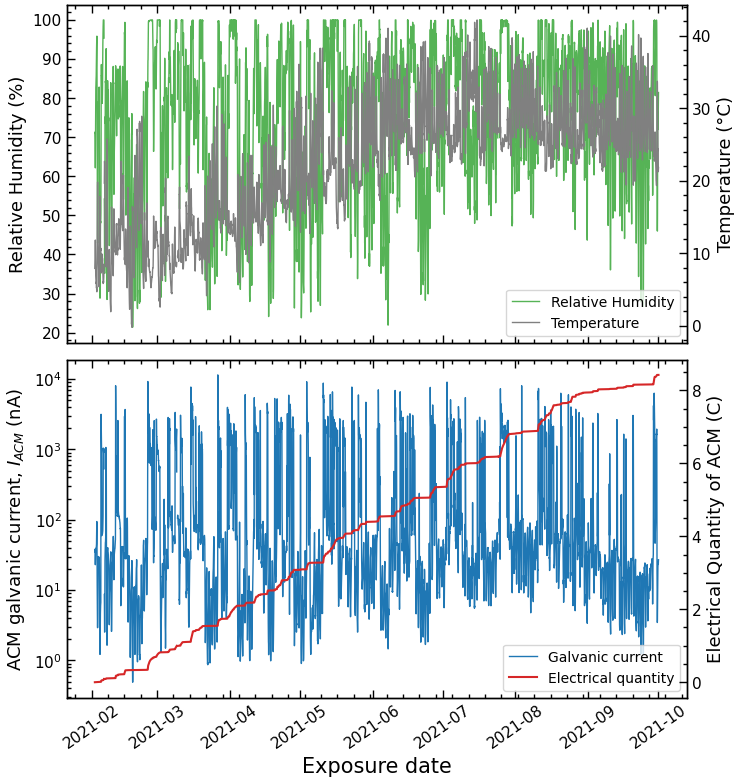

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(8, 9))

ax1_twin = axs[0].twinx()
axs[0].plot(df1['Relative Humidity (%)'].iloc[:int(len(df1)*0.68)], color=colors[2], label="Relative Humidity", linewidth=1, alpha = 0.8)
ax1_twin.plot(df1['Temperature (°C)'].iloc[:int(len(df1)*0.68)], color=colors[3], label="Temperature", linewidth=1)

axs[1].plot(df1['Galvanic current (nA)'].iloc[:int(len(df1)*0.68)], color=colors[0], label="Galvanic current", linewidth=1)
axs[1].set_yscale('log')

ax2_twin = axs[1].twinx()
ax2_twin.plot(df1['Electrical Quantity (C)'].iloc[:int(len(df1)*0.68)], color=colors[1], label="Electrical quantity", linewidth=1.5)

axs[0].set_ylabel("Relative Humidity (%)", fontsize=13)
ax1_twin.set_ylabel("Temperature (°C)", fontsize=13)
axs[1].set_ylabel("ACM galvanic current, $I_{ACM}$ (nA)", fontsize=13)
ax2_twin.set_ylabel("Electrical Quantity of ACM (C)", fontsize=13)

axs[1].tick_params(axis='x', labelsize=11)
axs[0].tick_params(axis='y', labelsize=11)
ax1_twin.tick_params(axis='y', labelsize=11)
axs[1].tick_params(axis='y', labelsize=11)
ax2_twin.tick_params(axis='y', labelsize=11)


plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

for ax in axs.flat:
    ax.set_xlabel("Exposure date", fontsize=15)

for tick in axs[1].get_xticklabels():
    tick.set_rotation(35)
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Adjust subplots spacing
fig.subplots_adjust(hspace=0.05)

# Combine legends for the first subplot
handles1, labels1 = axs[0].get_legend_handles_labels()
handles1_twin, labels1_twin = ax1_twin.get_legend_handles_labels()
axs[0].legend(handles1 + handles1_twin, labels1 + labels1_twin, loc='lower right', fontsize=10, frameon=True)

# Combine legends for the second subplot
handles2, labels2 = axs[1].get_legend_handles_labels()
handles2_twin, labels2_twin = ax2_twin.get_legend_handles_labels()
axs[1].legend(handles2 + handles2_twin, labels2 + labels2_twin, loc='lower right', fontsize=10, frameon=True)

fig.align_ylabels(axs[:])
plt.show()

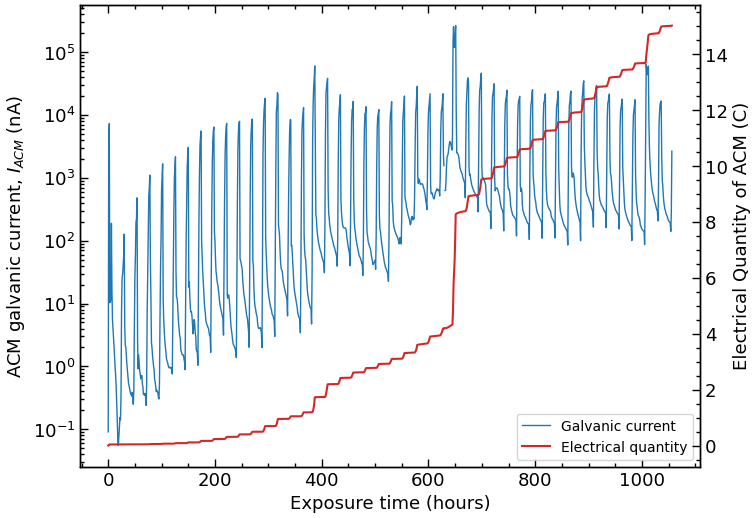

In [10]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(df_acc_sae['hours'], df_acc_sae['Galvanic current (nA)'].iloc[:], color=colors[0], label="Galvanic current", linewidth=1, alpha=1)
ax1.set_yscale('log')
ax1.set_ylabel("ACM galvanic current, $I_{ACM}$ (nA)", fontsize=13)
ax1.set_xlabel("Exposure time (hours)", fontsize=13)
ax1.tick_params(axis='both', labelsize=13, direction='in', right=False)
ax2 = ax1.twinx()
ax2.plot(df_acc_sae['hours'], df_acc_sae['Electrical Quantity (C)'].iloc[:], color=colors[1], label="Electrical quantity", linewidth=1.5)
ax2.set_ylabel("Electrical Quantity of ACM (C)", fontsize=13)
ax2.tick_params(axis='y', labelsize=13, direction='in')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="lower right", fontsize=10, frameon=True)

plt.show()


## Case study: Model trained on 1 week of data in winter to predict week in summer

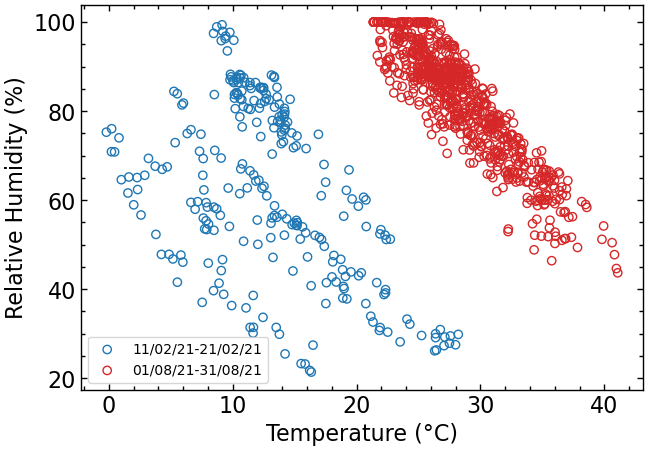

In [51]:
#Show graph of small distribution compared to other small distribution
fig, ax = plt.subplots(figsize=(9, 5))
fig.subplots_adjust(right=0.75)
# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.

p1 = ax.scatter(df1['Temperature (°C)']['2021-02-11':'2021-02-21'], df1['Relative Humidity (%)']['2021-02-11':'2021-02-21'], edgecolors=colors[0], label='11/02/21-21/02/21', facecolor='none', zorder=2)
p2 = ax.scatter(df1['Temperature (°C)']['2021-08-01':'2021-08-31'], df1['Relative Humidity (%)']['2021-08-01':'2021-08-31'], edgecolors=None, facecolor='none', label='01/08/21-31/08/21', alpha=1, color=colors[1], zorder=1)

ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Relative Humidity (%)")

tkw = dict(size=4, width=1)
ax.tick_params(axis='y', **tkw)
ax.tick_params(axis='x', **tkw)

# plt.legend(loc='upper left')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
ax.legend(handles=[p1, p2], fontsize=10, loc='lower left', frameon=True)
# ax.set_xticklabels([1, 2, 3, 4, 5, 6, 7 ,8])
# plt.rcParams['axes.linewidth'] = 1
# plt.title('Hourly mean temperature vs mean relative humidity', size=15)
plt.show()

## Transfer learning modelling

### Define all of the required functions

In [6]:
def error_function(inv_y, inv_yhat):
    error_rmse = mean_squared_error(
        y_true=inv_y,
        y_pred=inv_yhat,
        squared=False
    )
    r2 = r2_score(inv_y, inv_yhat)
    mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100
    return r2, error_rmse, mape


def predict_rescale(test_x, test_y, model, scaler_y):
    # predict the values
    yhat = model.predict(test_x, verbose=0)
    
    # rescale the data
    inv_yhat = scaler_y.inverse_transform(yhat)
    inv_y = scaler_y.inverse_transform(test_y.reshape(-1, 1))

    #test without scaling
#     inv_y = test_y.reshape(-1, 1)
#     inv_yhat = yhat

    inv_yhat[inv_yhat < 0] = 0
    return inv_y, inv_yhat


def DL_models(df, input_features, output_feature, node, epoch, split_size, learning_rate, batch_size, train_new, begin, end, add_layer=False, trainable=False, train_target=True, dropout=False, freeze_first_layer=False, freeze_second_layer=False):
    # get the values from the data preproces function 
    X = df[input_features].values
    y = df[output_feature].values
    
    split_index = int(len(X) * split_size)
    
    
    train_x, test_x = X[:split_index], X[int(len(X)*begin):int(len(X)*end)] # test 2 weeks in august
    train_y, test_y = y[:split_index], y[int(len(X)*begin):int(len(X)*end)] # test 2 weeks in august

#     # Scaling the data
    scaler_x = MinMaxScaler()
    train_x = scaler_x.fit_transform(train_x)
    test_x = scaler_x.transform(test_x)

    scaler_y = MinMaxScaler()
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1)).flatten()
    test_y = scaler_y.transform(test_y.reshape(-1, 1)).flatten()

    if train_new == True:
        model = Sequential()
        model.add(Dense(node, activation='relu', input_shape=(len(input_features),)))
        model.add(Dense(node-(node // 4), activation='relu'))
        if dropout:
            model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    else:
        model = train_new
        # Only freeze the first layer. since the first layer is a flatten, skip this
        for i, layer in enumerate(model.layers):
            layer.trainable = trainable
            if i==0 and freeze_first_layer:
                layer.trainable = False
            if i==1 and freeze_second_layer:
                layer.trainable = False

        # Check if we want to add an additional layer to train on. Is yes then remove the last Dense layer of the model and add An additional one
        model.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=learning_rate), loss='mse')
        if add_layer:
            model_new = Sequential()
            for layer in model.layers[:-1]:
                 model_new.add(layer)
            model_new.add(Dense(node - (node // 2), activation='relu'))
            model_new.add(Dense(1))
            model_new.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=learning_rate), loss='mse')
            model = model_new
        
    # call the fit and history plotter
    if train_target:
        history = model.fit(train_x, train_y, epochs=epoch, validation_data=(test_x, test_y), verbose=False, batch_size=batch_size)

    # call the predicter and rescaler
    inv_y, inv_yhat = predict_rescale(test_x, test_y, model, scaler_y)

    # converge the original and predicted data so that it can be used later on for plotting measures

    data_plot = pd.DataFrame(inv_yhat, index=df[output_feature].iloc[int(len(X)*begin):int(len(X)*end)].index, columns=['predictions'])
    input_features.append(output_feature)
    data = pd.merge(df[input_features], data_plot, left_index=True, right_index=True)  
    
    r2, error_rmse, mape = error_function(inv_y, inv_yhat)
    
    # calculate the electrical quantity:
    Q_True, Q_predicted = calculate_Q(data, 'Galvanic current (nA)', 'predictions')

    ranges = {'Below 150 nA':150, '150-500': 500, 'greater 500 nA': np.inf}
    range_acc = range_accuracy(inv_y, inv_yhat, ranges)
    
    results = pd.DataFrame({
        'split_size': [split_size],
        'model_type': ['MLP'],
        'epoch': epoch, 
        'nodes': node, 
        'learning_rate':learning_rate, 
        'extra layer': add_layer, 
        'freeze first':freeze_first_layer, 
        'freeze second':freeze_second_layer,
        'R2': [r2],
        'error_rmse': [error_rmse],
        'MAPE': [mape],
        'Electrical quantity true': [Q_True],
        'Electrical quantity predicted': [Q_predicted]
        
    })
    for label in ranges.keys():
        results[label] = range_acc[label]['accuracy']
    results['overal_accuracy'] = range_acc['overal_accuracy']
    return model, results


def r2_graph(df, algorithm):
    
    plt.style.use('default')
    plt.style.use(['science', 'notebook'])
    x = df[df.columns[-2]] # true value
    y = df[df.columns[-1]] # predicted value
    #calcualte the r2
    r2 = r2_score(x, y)
    b, a = np.polyfit(x, y, deg=1)
    fig, ax = plt.subplots(figsize = (9, 9))
    ax.scatter(x, y, marker='^', alpha=0.5, edgecolors = 'red' )
    ax.plot(x, a + b * x, color="k", lw=1);
    ax.set_xlabel("True "+x.name)
    ax.set_ylabel("Predicted "+x.name)
    plt.figtext(0.16,0.8, 'R\u00b2 = %0.2f' % r2, fontsize=15, bbox=dict(facecolor='none', edgecolor='black',pad=14.0))
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.title(algorithm + ' testing set results')
    plt.show()

    # now plot the actual vs predicted over the testing time
    fig, ax = plt.subplots(figsize = (13, 6))
    ax.plot(x.index, x, label='Actual', fillstyle='none')
    ax.plot(y.index, y, lw=1, label='Predicted', color='red');
    ax.set_xlabel('Exposure date')
    ax.set_ylabel("Predicted "+x.name)
    plt.figtext(0.16,0.8, 'R\u00b2 = %0.2f' % r2, fontsize=15, bbox=dict(facecolor='none', edgecolor='black',pad=14.0))
    plt.title(algorithm + ' testing set results over time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tick_params(axis='x', which='minor', bottom=False, top=False)
    plt.show()
    

def history_plot(history_noTL, history_TL, file_name):
    plt.style.use('default')
    plt.style.use(['science', 'notebook'])
    history_no_TL = history_noTL.history['val_loss']
    history_with_TL = history_TL.history['val_loss']
    plt.plot(history_no_TL, label = 'From scratch model', color = 'b')
    plt.plot(history_with_TL, label = 'Transfer learning model', color = 'r')
    # now plot the actual vs predicted over the testing time
    plt.xlim(min(range(len(history_no_TL))), max(range(len(history_no_TL))))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(frameon=True)
    plt.tick_params(axis='x', which='minor', bottom=False, top=False)
#     plt.savefig(file_name)
    plt.show()
    
def calculate_Q(data, actual, predicted):
    data['Electrical Quantity (C)'] = data[actual].cumsum()
    data['Electrical Quantity (C)'] = data['Electrical Quantity (C)'] * 0.00000006 * 60
    Q_true = data['Electrical Quantity (C)'].iloc[-1]
    
    data['Electrical Quantity (C)'] = data[predicted].cumsum()
    data['Electrical Quantity (C)'] = data['Electrical Quantity (C)'] * 0.00000006 * 60
    Q_predicted = data['Electrical Quantity (C)'].iloc[-1]
    
    return Q_true, Q_predicted


def range_accuracy(y_true, y_pred, ranges):
    range_labels = list(ranges.keys())
    range_bins = [-np.inf] + list(ranges.values())

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    true_labels = pd.cut(y_true, bins=range_bins, labels=range_labels, right=False)
    pred_labels = pd.cut(y_pred, bins=range_bins, labels=range_labels, right=False)

    range_accuracies = {}
    total_correct_preds = 0  # Initialize the variable before the loop
    for label in range_labels:
        mask = true_labels == label
        correct_preds = np.sum(true_labels[mask] == pred_labels[mask])
        total_samples = np.sum(mask)
        range_accuracies[label] = {
            'accuracy': correct_preds / total_samples if total_samples > 0 else 0,
            'total_samples': total_samples,
            'correct_preds': correct_preds
        }
        total_correct_preds += correct_preds  # Increment the variable in the loop

    range_accuracies['total_correct_preds'] = total_correct_preds
    range_accuracies['total_samples'] = len(y_pred)
    range_accuracies['overal_accuracy'] = range_accuracies['total_correct_preds']/range_accuracies['total_samples']
    return range_accuracies


def create_lstm(hidden_nodes, lr):
    model = Sequential()
    model.add(LSTM(hidden_nodes, activation='relu', input_shape=(2, 1)))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    return model


def create_cnn(hidden_nodes, lr):
    model = Sequential()
    model.add(Conv1D(filters=hidden_nodes, kernel_size=2, activation='relu', input_shape=(2, 1)))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    return model


def calculate_r2_scores_other_models(df, input_features, output_feature, split_size, nodes, epochs, lr, begin, end):
    # Fixed hyperparameters for each model
    
    ranges = {'Below 150 nA':150, '150-500': 500, 'greater 500 nA': np.inf}
#     mlp_params = {'hidden_nodes': 20, 'lr': 0.0001, 'epochs': 200, 'batch_size': 16}
    lstm_cnn_params = {'hidden_nodes': nodes, 'lr': lr, 'epochs': epochs, 'batch_size': 16}
    rf_params = {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 10}
    svm_params = {'C': 100, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}
    
    X = df[input_features].values
    y = df[output_feature].values
    
    # Train-test split
    split_index = int(len(X) * split_size)
    
    X_train, X_test = X[:split_index], X[int(len(X)*begin):int(len(X)*end)] # test 2 weeks in august
    y_train, y_test = y[:split_index], y[int(len(X)*begin):int(len(X)*end)] # test 2 weeks in august
    
    # Scaling the data
    scaler_X = MinMaxScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)
    
    scaler_y = MinMaxScaler()
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    y_test_orig = y_test
    y_test_orig = scaler_y.inverse_transform(y_test_orig.reshape(-1, 1)).flatten()

   # Train and test LSTM
    lstm = create_lstm(lstm_cnn_params['hidden_nodes'], lstm_cnn_params['lr'])
    lstm.fit(X_train.reshape(-1, len(input_features), 1), y_train, epochs=lstm_cnn_params['epochs'], batch_size=lstm_cnn_params['batch_size'], verbose=0)
    y_pred_lstm = lstm.predict(X_test.reshape(-1, len(input_features), 1))
    

    # Train and test CNN
    cnn = create_cnn(lstm_cnn_params['hidden_nodes'], lstm_cnn_params['lr'])
    cnn.fit(X_train.reshape(-1, len(input_features), 1), y_train, epochs=lstm_cnn_params['epochs'], batch_size=lstm_cnn_params['batch_size'], verbose=0)
    y_pred_cnn = cnn.predict(X_test.reshape(-1, len(input_features), 1))
    
    # Train and test RF
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    # Train and test SVM
    svm = SVR(**svm_params)
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    
    # Rescale predictions back to their original range
    input_features.append(output_feature)
    y_pred_lstm_orig = scaler_y.inverse_transform(y_pred_lstm)
    y_pred_lstm_orig[y_pred_lstm_orig < 0] = 0
    # merge the data together again
    data_plot_lstm = pd.DataFrame(y_pred_lstm_orig, index=df[output_feature].iloc[int(len(X)*begin):int(len(X)*end)].index, columns=['predictions'])
    data_lstm = pd.merge(df[input_features], data_plot_lstm, left_index=True, right_index=True)  
    Q_True_lstm, Q_predicted_lstm = calculate_Q(data_lstm, 'Galvanic current (nA)', 'predictions')
    r2_lstm, error_rmse_lstm, mape_lstm = error_function(y_test_orig, y_pred_lstm_orig)
    
    y_pred_cnn_orig = scaler_y.inverse_transform(y_pred_cnn)
    y_pred_cnn_orig[y_pred_cnn_orig < 0] = 0
    # merge the data together again
    data_plot_cnn = pd.DataFrame(y_pred_cnn_orig, index=df[output_feature].iloc[int(len(X)*begin):int(len(X)*end)].index, columns=['predictions'])
    data_cnn = pd.merge(df[input_features], data_plot_cnn, left_index=True, right_index=True)  
    Q_True_cnn, Q_predicted_cnn = calculate_Q(data_cnn, 'Galvanic current (nA)', 'predictions')
    r2_cnn, error_rmse_cnn, mape_cnn = error_function(y_test_orig, y_pred_cnn_orig)
    
    y_pred_rf_orig = scaler_y.inverse_transform(y_pred_rf.reshape(-1, 1))
    y_pred_rf_orig[y_pred_rf_orig < 0] = 0
    # merge the data together again
    data_plot_rf = pd.DataFrame(y_pred_rf_orig, index=df[output_feature].iloc[int(len(X)*begin):int(len(X)*end)].index, columns=['predictions'])
    data_rf = pd.merge(df[input_features], data_plot_rf, left_index=True, right_index=True)  
    Q_True_rf, Q_predicted_rf = calculate_Q(data_rf, 'Galvanic current (nA)', 'predictions')
    r2_rf, error_rmse_rf, mape_rf = error_function(y_test_orig, y_pred_rf_orig)
    
    y_pred_svm_orig = scaler_y.inverse_transform(y_pred_svm.reshape(-1, 1))
    y_pred_svm_orig[y_pred_svm_orig < 0] = 0
    # merge the data together again
    data_plot_svm = pd.DataFrame(y_pred_svm_orig, index=df[output_feature].iloc[int(len(X)*begin):int(len(X)*end)].index, columns=['predictions'])
    data_svm = pd.merge(df[input_features], data_plot_svm, left_index=True, right_index=True)  
    Q_True_svm, Q_predicted_svm = calculate_Q(data_svm, 'Galvanic current (nA)', 'predictions')
    r2_svm, error_rmse_svm, mape_svm = error_function(y_test_orig, y_pred_svm_orig)

    # Calculate range accuracies with rescaled predictions
    range_acc_lstm = range_accuracy(y_test_orig, y_pred_lstm_orig, ranges)
    range_acc_cnn = range_accuracy(y_test_orig, y_pred_cnn_orig, ranges)
    range_acc_rf = range_accuracy(y_test_orig, y_pred_rf_orig, ranges)
    range_acc_svm = range_accuracy(y_test_orig, y_pred_svm_orig, ranges)
    

    results = pd.DataFrame({
        'split_size': [split_size, split_size, split_size, split_size],
        'Transfer learning': [False, False, False, False],
        'model_type': ['LSTM', 'CNN', 'RF', 'SVM'],
        'R2': [r2_lstm, r2_cnn, r2_rf, r2_svm],
        'error_rmse': [error_rmse_lstm, error_rmse_cnn, error_rmse_rf, error_rmse_svm],
        'MAPE': [mape_lstm, mape_cnn, mape_rf, mape_svm],
        'Electrical quantity true': [Q_True_lstm, Q_True_cnn, Q_True_rf, Q_True_svm],
        'Electrical quantity predicted': [Q_predicted_lstm, Q_predicted_cnn, Q_predicted_rf, Q_predicted_svm],
        'overal_accuracy': [range_acc_lstm['overal_accuracy'], range_acc_cnn['overal_accuracy'], range_acc_rf['overal_accuracy'], range_acc_svm['overal_accuracy']]
        
    })

    # Add quantile accuracy columns to the results dataframe
    for label in ranges.keys():
        results[label] = [range_acc_lstm[label]['accuracy'], range_acc_cnn[label]['accuracy'], range_acc_rf[label]['accuracy'], range_acc_svm[label]['accuracy']]
    
    return results


In [5]:
# The following code is for transfer learning only. It is the same as the code above but the data is scaled on both source and target
def categorize_predictions(inv_y, inv_yhat, ranges):
    y_true_cat, y_pred_cat = [], []

    for true, pred in zip(inv_y, inv_yhat):
        for label, threshold in ranges.items():
            if true <= threshold:
                y_true_cat.append(label)
                break

        for label, threshold in ranges.items():
            if pred <= threshold:
                y_pred_cat.append(label)
                break

    return y_true_cat, y_pred_cat


def calculate_f1_macro_average(y_true_cat, y_pred_cat, ranges):
    f1 = f1_score(y_true_cat, y_pred_cat, average=None, labels=list(ranges.keys()))
    macro_avg_f1 = f1_score(y_true_cat, y_pred_cat, average='macro')
    return f1, macro_avg_f1


def error_function(inv_y, inv_yhat):
    error_rmse = mean_squared_error(
        y_true=inv_y,
        y_pred=inv_yhat,
        squared=False
    )
    r2 = r2_score(inv_y, inv_yhat)
    mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100
    return r2, error_rmse, mape


def predict_rescale(test_x, test_y, model, scaler_y):
    # predict the values
    yhat = model.predict(test_x, verbose=0)
    
    # rescale the data
    inv_yhat = scaler_y.inverse_transform(yhat)
    inv_y = scaler_y.inverse_transform(test_y.reshape(-1, 1))

    inv_yhat[inv_yhat < 0] = 0
    return inv_y, inv_yhat


def DL_models_TL(df, df_acc, input_features, output_feature, node, epoch, split_size, learning_rate, batch_size, train_new, begin, end, add_layer=False, trainable=False, train_target=True, dropout=False, freeze_first_layer=False, freeze_second_layer=False, test_lim=True):
    # get the values from the data preproces function 
    X = df[input_features].values
    y = df[output_feature].values
    
    X_acc = df_acc[input_features].values
    y_acc = df_acc[output_feature].values
    
    split_index = int(len(X) * split_size)
    
    if test_lim:
        train_x, test_x = X[:split_index], X[int(len(X)*begin):int(len(X)*end)] # test 2 week in august
        train_y, test_y = y[:split_index], y[int(len(X)*begin):int(len(X)*end)] # test 2 week in august
    else:
        train_x, test_x = X[:split_index], X[split_index:] # test 2 week in august
        train_y, test_y = y[:split_index], y[split_index:] # test 2 week in august
# Scaling the data
    
    X_all = np.concatenate((train_x, X_acc))
    Y_all = np.concatenate((train_y, y_acc))

    scaler_x = MinMaxScaler()
    scaler_x.fit(X_all)
    train_x = scaler_x.transform(train_x)
    test_x = scaler_x.transform(test_x)

    scaler_y = MinMaxScaler()
    scaler_y.fit(Y_all.reshape(-1, 1))
    train_y = scaler_y.transform(train_y.reshape(-1, 1)).flatten()
    test_y = scaler_y.transform(test_y.reshape(-1, 1)).flatten()

    if train_new == True:
        model = Sequential()
        model.add(Dense(node, activation='relu', input_shape=(2,)))
        model.add(Dense(node-(node // 4), activation='relu'))
        if dropout:
            model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    else:
        model = train_new
        # Only freeze the first layer. since the first layer is a flatten, skip this
        for i, layer in enumerate(model.layers):
            layer.trainable = trainable
            if i==0 and freeze_first_layer:
                layer.trainable = False
            if i==1 and freeze_second_layer:
                layer.trainable = False

        # Check if we want to add an additional layer to train on. Is yes then remove the last Dense layer of the model and add An additional one
        model.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=learning_rate), loss='mse')
        if add_layer:
            model_new = Sequential()
            for layer in model.layers[:-1]:
                 model_new.add(layer)
            model_new.add(Dense(node - (node // 2), activation='relu'))
            model_new.add(Dense(1))
            model_new.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=learning_rate), loss='mse')
            model = model_new
        
    # call the fit and history plotter
    if train_target:
        history = model.fit(train_x, train_y, epochs=epoch, validation_data=(test_x, test_y), verbose=False, batch_size=batch_size)

    # call the predicter and rescaler
    inv_y, inv_yhat = predict_rescale(test_x, test_y, model, scaler_y)

    # converge the original and predicted data so that it can be used later on for plotting measures
    if test_lim:
        data_plot = pd.DataFrame(inv_yhat, index=df[output_feature].iloc[int(len(X)*begin):int(len(X)*end)].index, columns=['predictions'])
    else:
        data_plot = pd.DataFrame(inv_yhat, index=df[output_feature].iloc[split_index:].index, columns=['predictions'])
    input_features.append(output_feature)
    data = pd.merge(df[input_features], data_plot, left_index=True, right_index=True)  
    
    r2, error_rmse, mape = error_function(inv_y, inv_yhat)

    # calculate the electrical quantity:
    Q_True, Q_predicted = calculate_Q(data, 'Galvanic current (nA)', 'predictions')
    
    ranges = {'Below 150 nA':150, '150-500': 500, 'greater 500 nA': np.inf}
    range_acc = range_accuracy(inv_y, inv_yhat, ranges)
    
    results = pd.DataFrame({
        'split_size': [split_size],
        'model_type': ['MLP'],
        'epoch': epoch, 
        'nodes': node, 
        'learning_rate':learning_rate, 
        'extra layer': add_layer, 
        'freeze first':freeze_first_layer, 
        'freeze second':freeze_second_layer,
        'R2': [r2],
        'error_rmse': [error_rmse],
        'MAPE': [mape],
        'Electrical quantity true': [Q_True],
        'Electrical quantity predicted': [Q_predicted]
        
    })
    for label in ranges.keys():
        results[label] = range_acc[label]['accuracy']
    results['overal_accuracy'] = range_acc['overal_accuracy']
    
#     for i, label in enumerate(ranges.keys()):
#         results[f'F1_score_{label}'] = f1[i]
#     results['macro_average_F1'] = macro_avg_f1
    
    return model, results

### Hyperparameter optimization
Prior modelling found that a hyperparameter setting of {batchsize:4, epoch:300, activation functions: ReLu, optimizer: Adam, Nodes in hidden layer:20 and 14} was most effective. The following code tries to find what the best transfer learning approach is out of the 4 possibilities is the best: freezing the first layer, freezing the second layer, adding an extra layer and freezing all layers for different learning rates. The results are then stored in an excel file for further analysation 

In [ ]:
begin_testsplit = [0.4198, 0.51, 0.595] # three months
end_testsplit = [0.509, 0.595, 0.6797]
week_size = 0.02
num_weeks = 20
split_sizes_test = [week_size * i for i in range(1, num_weeks + 1)]
learning_rates = [0.0001, 0.00001, 0.000001]
booleans = [False, True]
epoch = 300
node = 20
batch_size = 4
type_model = 'Classic sequential FFNN'
df_main = pd.DataFrame(columns=['split_size', 'Transfer learning', 'model_type', 'epoch', 'nodes', 'learning_rate', 'extra layer', 'freeze first', 'freeze second', 'Source', 'Target', 
                                 'R2', 'error_rmse', 'MAPE', 'Electrical quantity true', 'Electrical quantity predicted', 
                                 'Below 150 nA', '150-500', 'greater 500 nA', 'overal_accuracy', 'begin_testsplit', 'end_testsplit'])

# Remove the nan values as the models dont work with these values
df1.dropna(inplace=True)
df_acc_sae.dropna(inplace=True)
sources_dict = {'Complete salt spray test':df_acc_sae}
targets_dict = {'Outdoor exposure test 1': df1}

for idx, (begin_split, end_split) in enumerate(zip(begin_testsplit, end_testsplit)):
# First test all the models without transfer learning
    for target_type, target_ in targets_dict.items():
        for split_size in split_sizes_test:
            input_features = ['Temperature (°C)', 'Relative Humidity (%)']
            target_feature = 'Galvanic current (nA)'
            model, results = DL_models(target_, input_features, target_feature, node, epoch, split_size, 0.0001, batch_size, True, begin_split, end_split)
            results['Transfer learning'] = False
            results['Target'] = target_type
            results['begin_testsplit'] = begin_split  # Add begin_testsplit value to the results DataFrame
            results['end_testsplit'] = end_split  # Add end_testsplit value to the results DataFrame
            df_main = pd.concat([df_main.reset_index(drop=True), results.reset_index(drop=True)], axis=0, ignore_index=True)
            input_features = ['Temperature (°C)', 'Relative Humidity (%)']
            target_feature = 'Galvanic current (nA)'
            results = calculate_r2_scores_other_models(target_, input_features, target_feature, split_size, node, epoch, 0.0001, begin_split, end_split)
            results['Transfer learning'] = False
            results['Target'] = target_type
            results['begin_testsplit'] = begin_split  # Add begin_testsplit value to the results DataFrame
            results['end_testsplit'] = end_split  # Add end_testsplit value to the results DataFrame
            df_main = pd.concat([df_main.reset_index(drop=True), results.reset_index(drop=True)], axis=0, ignore_index=True)

    # Now test the transfer learning approaches
    for source_type, source_ in sources_dict.items():
        for split_size in split_sizes_test:
            for target_type, target_ in targets_dict.items():
                print(str(source_type)+' is the source being tested at the moment :)')
                input_features = ['Temperature (°C)', 'Relative Humidity (%)']
                target_feature = 'Galvanic current (nA)'
                loaded_model, results_source = DL_models_TL(source_, target_.iloc[:int(len(target_)*split_size)], input_features, target_feature, node, epoch, 0.90, 0.0001, batch_size, True, begin_split, end_split, test_lim=False)
                # now save the model to be used on the outdoor data set
                loaded_model.save('MLP_h5.h5', save_format='h5')
                for learning_rate in learning_rates:
                    print(str(learning_rate)+' is the source being tested at the moment :)')
                    for extra_layer in booleans:
                        for freeze_first_ in booleans:
                            if extra_layer==True & freeze_first_==True:
                                continue
                            for freeze_second_ in booleans:
                                if extra_layer==True & freeze_second_==True:
                                    continue
                                input_features = ['Temperature (°C)', 'Relative Humidity (%)']
                                target_feature = 'Galvanic current (nA)'
                                loaded_model = tf.keras.models.load_model('MLP_h5.h5')
                                model, results = DL_models_TL(target_, target_.iloc[:int(len(target_)*split_size)], input_features, target_feature, 
                                                                              node, epoch, split_size, learning_rate, batch_size, loaded_model, begin_split, end_split, add_layer=extra_layer, 
                                                                              trainable=not extra_layer, freeze_first_layer=freeze_first_, 
                                                                              freeze_second_layer=freeze_second_)
                                results['Transfer learning'] = True
                                results['Source'] = source_type
                                results['Target'] = target_type
                                results['begin_testsplit'] = begin_split  # Add begin_testsplit value to the results DataFrame
                                results['end_testsplit'] = end_split  # Add end_testsplit value to the results DataFrame
                                df_main = pd.concat([df_main.reset_index(drop=True), results.reset_index(drop=True)], axis=0, ignore_index=True)


df_main.to_excel("Modelling_results_TL_benchmark_july_august_september_all_data.xlsx")

### Code for the case study

In [ ]:
begin_testsplit = 0.51 
end_testsplit = 0.595 
epoch = 300
batch_size = 4
node = 20

def categorize_values(value):
    intervals = [(0, 150), (150, 500), (500, float('inf'))]

    for index, (low, high) in enumerate(intervals):
        if low <= value < high:
            return index

    raise ValueError(f"Value {value} doesn't belong to any of the defined intervals.")


def plot_custom_heatmap_v3(df, title, cmap='Oranges', annot=True, fmt='.0f', cbar=False):
    fig, ax = plt.subplots(figsize=(5, 5))

    data = pd.DataFrame(index=df.index, columns=['Total', 'Correct', 'Accuracy'])

    data['Total'] = df['Total']
    data['Correct'] = df['Actual']
    data['Accuracy'] = df['Accuracy']

    # Create a custom colormap
    custom_cmap = sns.color_palette(['white', 'white'])
    custom_cmap.extend(sns.color_palette(cmap, 254))

    # Only apply color to the Accuracy column
    norm_data_color = data.copy()
    norm_data_color['Total'] = 0
    norm_data_color['Correct'] = 0
    norm_data_color['Accuracy'] = norm_data_color['Accuracy'] / 100

    sns.heatmap(norm_data_color, annot=data, fmt=fmt, cmap=custom_cmap, ax=ax, cbar=cbar, vmin=0, vmax=1,
                linewidths=1, linecolor='black', annot_kws={'size': 20})

    ax.set_xticklabels(['Total', 'Correct', 'Accuracy (%)'], fontsize=15, rotation=0)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    ax.set_yticklabels(df.index, fontsize=15, rotation=0)

    # Remove tick markers
    ax.tick_params(which='both', left=False, bottom=False, top=False, right=False)

    ax.set_title(title, fontsize=14)
    plt.show()


def calculate_accuracy(data, actual_col='Galvanic current (nA)', predicted_col='predictions'):
    data['correct'] = data.apply(lambda row: categorize_values(row[actual_col]) == categorize_values(row[predicted_col]), axis=1)
    
    intervals = [(0, 150), (150, 500), (500, float('inf'))]
    results = []
    for low, high in intervals:
        mask = (data[actual_col] >= low) & (data[actual_col] < high)
        filtered_data = data[mask]
        correct = filtered_data['correct'].sum()
        total = len(filtered_data)
        results.append((correct, total - correct, correct / total if total > 0 else 0))
    
    all_correct = data['correct'].sum()
    all_total = len(data)
    results.append((all_correct, all_total - all_correct, all_correct / all_total))
    return results

# train source model
split_size = 0.9
learning_rate = 0.0001
input_features = ['Temperature (°C)', 'Relative Humidity (%)']
target_feature = 'Galvanic current (nA)'
df_acc_sae.dropna(inplace=True)
model, results, data, history = DL_models_TL(df_acc_sae, df1.iloc[:int(len(df1)*0.02)], input_features, target_feature, node, epoch, split_size, learning_rate, batch_size, True, begin_testsplit, end_testsplit, test_lim=False)
print(results)
# now save the model to be used on the outdoor data set
model.save('MLP_accelerated_experiment_h5.h5', save_format='h5')
plt.style.use('default')
plt.style.use(['science', 'notebook'])
fig, ax = plt.subplots(figsize=(9, 5))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot(data['Galvanic current (nA)'], label='testing data', color=colors[3])
plt.plot(data['predictions'], label='predictions', color=colors[2])
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Galvanic current (nA)', fontsize=18)
ax.tick_params(axis='x', labelsize=13)
plt.title('Hourly predictions of ACM sensor galvanic current', size=13)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.legend(fontsize=12, frameon=True)
plt.show()

# transfer learning
split_size = 0.02
loaded_model = tf.keras.models.load_model('MLP_accelerated_experiment_h5.h5')
extra_layer = False
learning_rate = 0.00001
freeze_first_ = True
freeze_second_ = False
input_features = ['Temperature (°C)', 'Relative Humidity (%)']
target_feature = 'Galvanic current (nA)'

model_TL, results_TL, data_TL, history_TL = DL_models_TL(df1, df1.iloc[:int(len(df1)*split_size)], input_features, target_feature, 
                                                                      node, epoch, split_size, learning_rate, batch_size, loaded_model, begin_testsplit, end_testsplit, add_layer=extra_layer, 
                                                                      trainable=not extra_layer, freeze_first_layer=freeze_first_, 
                                                                      freeze_second_layer=freeze_second_)
print(results_TL)
plt.style.use('default')
plt.style.use(['science', 'notebook'])
fig, ax = plt.subplots(figsize=(9, 5))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot(data_TL['Galvanic current (nA)'], label='testing data', color=colors[3])
plt.plot(data_TL['predictions'], label='predictions', color=colors[2])
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Galvanic current (nA)', fontsize=18)
ax.tick_params(axis='x', labelsize=13)
#     plt.title('Hourly predictions of ACM sensor galvanic current', size=13)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.legend(fontsize=12, frameon=True)
plt.show()

# no transfer learning
split_size = 0.02
loaded_model = tf.keras.models.load_model('MLP_accelerated_experiment_h5.h5')
extra_layer = False
learning_rate = 0.0001
freeze_first_ = True
freeze_second_ = False
input_features = ['Temperature (°C)', 'Relative Humidity (%)']
target_feature = 'Galvanic current (nA)'

model_noTL, results_noTL, data_noTL, history_noTL = DL_models(df1, input_features, target_feature, 
                                                                      node, epoch, split_size, learning_rate, batch_size, True, begin_testsplit, end_testsplit, add_layer=extra_layer, 
                                                                      trainable=not extra_layer, freeze_first_layer=freeze_first_, 
                                                                      freeze_second_layer=freeze_second_)
print(results_noTL)
plt.style.use('default')
plt.style.use(['science', 'notebook'])
fig, ax = plt.subplots(figsize=(9, 5))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot(data_noTL['Galvanic current (nA)'], label='testing data', color=colors[3])
plt.plot(data_noTL['predictions'], label='predictions', color=colors[2])
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Galvanic current (nA)', fontsize=18)
ax.tick_params(axis='x', labelsize=13)
#     plt.title('Hourly predictions of ACM sensor galvanic current', size=13)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.legend(fontsize=12, frameon=True)
plt.show()

history_plot(history_noTL, history_TL, 'MLP')
index_labels = ['0-150', '150-500', '>500', 'All']
column_labels = ['Actual', 'Predicted', 'Accuracy']

results_df_TL = calculate_accuracy(data_TL)
results_df_noTL = calculate_accuracy(data_noTL)

results_df_TL = pd.DataFrame(results_df_TL, columns=column_labels, index=index_labels)
results_df_noTL = pd.DataFrame(results_df_noTL, columns=column_labels, index=index_labels)

results_df_TL['Total'] = results_df_TL['Actual'] + results_df_TL['Predicted']
results_df_noTL['Total'] = results_df_noTL['Actual'] + results_df_noTL['Predicted']

results_df_TL['Accuracy'] = results_df_TL['Accuracy'] * 100
results_df_noTL['Accuracy'] = results_df_noTL['Accuracy'] * 100


plot_custom_heatmap_v3(results_df_TL, 'Transfer Learning Accuracy')
plot_custom_heatmap_v3(results_df_noTL, 'No Transfer Learning Accuracy')

### Support the resampling of the data to hourly data

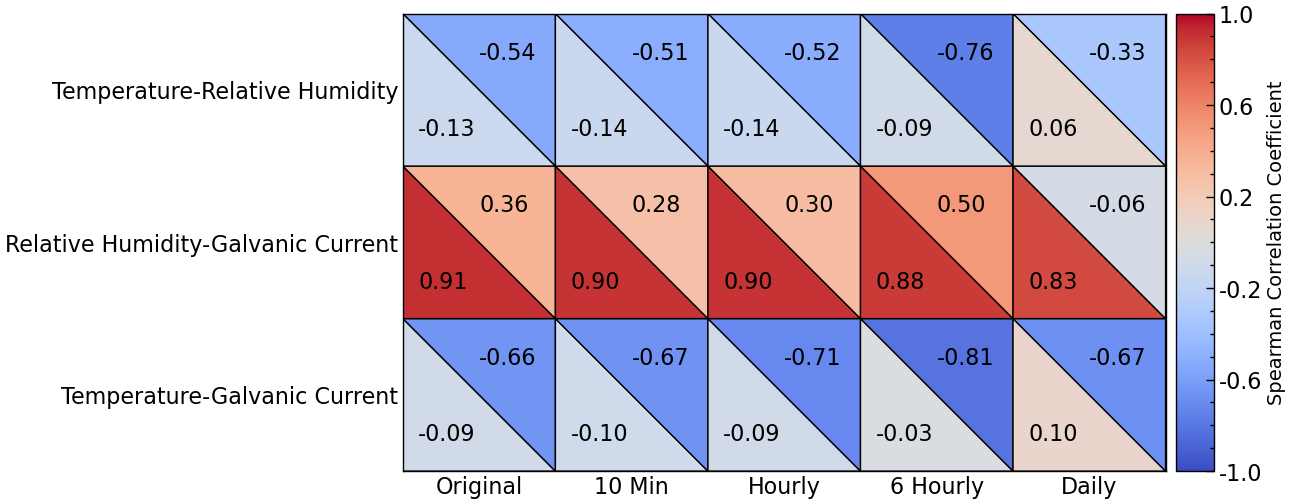

In [14]:
input_features = ['Temperature (°C)', 'Relative Humidity (%)']
target_feature = 'Galvanic current (nA)'
resampling_frequencies = {'10 Min':'10min', 'Hourly':'H', '6 Hourly':'6H', 'Daily':'D'}

def calculate_spearman(df):
    spearman_results = {
        'Original': {},
        '10 Min': {},
        'Hourly': {},
        '6 Hourly': {},
        'Daily': {}
    }

    # Calculate correlations for the original dataset (minute data)
    spearman_corr_temp_original = spearmanr(df['Temperature (°C)'], df[target_feature])
    spearman_corr_rh_original = spearmanr(df['Relative Humidity (%)'], df[target_feature])
    spearman_corr_temp_rh_original = spearmanr(df['Temperature (°C)'], df['Relative Humidity (%)'])

    spearman_results['Original'] = {
        'Temperature-Galvanic Current': spearman_corr_temp_original.correlation,
        'Relative Humidity-Galvanic Current': spearman_corr_rh_original.correlation,
        'Temperature-Relative Humidity': spearman_corr_temp_rh_original.correlation
    }

    for key, freq in resampling_frequencies.items():
        df_resampled = df.resample(freq).mean()
        df_resampled.dropna(inplace=True)

        spearman_corr_temp = spearmanr(df_resampled['Temperature (°C)'], df_resampled[target_feature])
        spearman_corr_rh = spearmanr(df_resampled['Relative Humidity (%)'], df_resampled[target_feature])
        spearman_corr_temp_rh = spearmanr(df_resampled['Temperature (°C)'], df_resampled['Relative Humidity (%)'])

        spearman_results[key] = {
            'Temperature-Galvanic Current': spearman_corr_temp.correlation,
            'Relative Humidity-Galvanic Current': spearman_corr_rh.correlation,
            'Temperature-Relative Humidity': spearman_corr_temp_rh.correlation
        }

    return pd.DataFrame(spearman_results)


def plot_custom_heatmap(df1, df2):
    spearman_df1 = calculate_spearman(df1)
    spearman_df2 = calculate_spearman(df2)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_aspect('equal')  # Set the aspect ratio to make squares

    # Add additional space for the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    norm = plt.Normalize(vmin=-1, vmax=1)
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    cbar = plt.colorbar(sm, ax=ax, cax=cax, orientation='vertical')
    cbar.ax.set_ylabel('Spearman Correlation Coefficient', fontsize=14)
    
    # Define the ticks and their labels
    ticks_loc = np.arange(-1, 1.1, 0.4)
    ticks_label = [f'{i:.1f}' for i in ticks_loc]

    # Set the ticks and their labels
    cbar.locator = FixedLocator(ticks_loc)
    cbar.formatter = FixedFormatter(ticks_label)

    # Need to manually update the ticks, or it won't show up
    cbar.update_ticks()

    # Plot the diagonal colors and values for each cell
    for i in range(spearman_df1.shape[0]):
        for j in range(spearman_df1.shape[1]):
            ax.add_patch(Polygon([(j, i), (j+1, i), (j, i+1)], closed=True, facecolor=plt.cm.coolwarm(norm(spearman_df1.iat[i, j])), edgecolor='black'))
            ax.add_patch(Polygon([(j, i+1), (j+1, i), (j+1, i+1)], closed=True, facecolor=plt.cm.coolwarm(norm(spearman_df2.iat[i, j])), edgecolor='black'))

            # Add annotations
            ax.text(j + 0.1, i + 0.2, f"{spearman_df1.iat[i, j]:.2f}", fontsize=16, color='black')
            ax.text(j + 0.5, i + 0.7, f"{spearman_df2.iat[i, j]:.2f}", fontsize=16, color='black')


    # Set plot details
    ax.set_xticks(np.arange(spearman_df1.shape[1]) + 0.5)
    ax.set_yticks(np.arange(spearman_df1.shape[0]) + 0.5)
    ax.set_xticklabels(spearman_df1.columns)
    ax.set_yticklabels(spearman_df1.index)

    ax.tick_params(left=False, bottom=False, top=False, right=False, which='both')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    # Remove white spaces by setting the plot limits
    ax.set_xlim(0, spearman_df1.shape[1])
    ax.set_ylim(0, spearman_df1.shape[0])

    plt.tight_layout()
    plt.show()

# Plot the custom heatmap
plot_custom_heatmap(df1, df_acc_sae)

### EDA that shows that the hourly data can be used

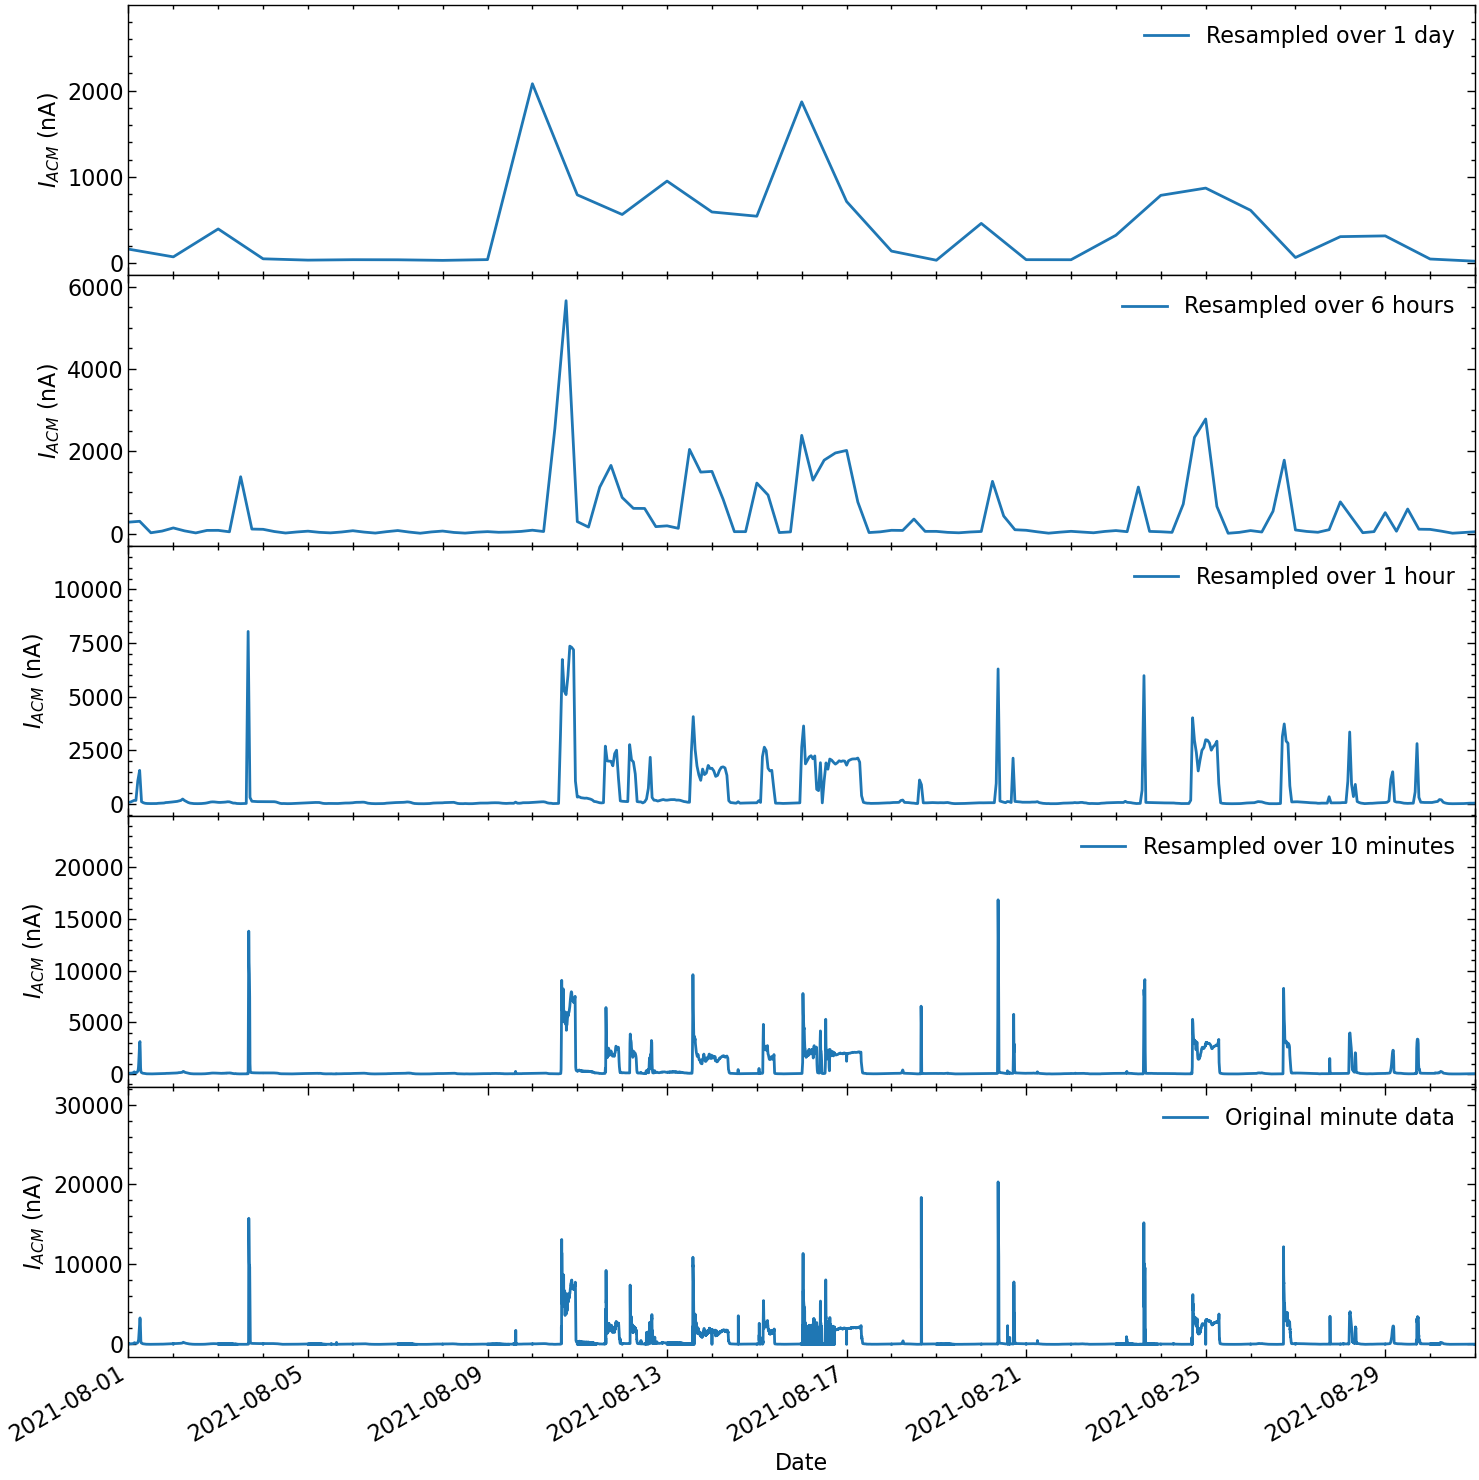

In [22]:
# Create a figure and an array of subplots with 5 rows and 1 column
fig, ax = plt.subplots(5, 1, figsize=(15,15))
plt.style.use('default')
plt.style.use(['science', 'notebook'])
# Plotting the 'Galvanic current (nA)' column resampled over different time intervals
df1_ = df1
df1_['Galvanic current (nA)'].resample('D').mean().plot(ax=ax[0], color=colors[0])
ax[0].set_ylabel('$I_{ACM}$ (nA)')
ax[0].xaxis.set_ticklabels([])
ax[0].legend(['Resampled over 1 day'], loc='upper right')

df1_ = df1

df1_['Galvanic current (nA)'].resample('6H').mean().plot(ax=ax[1], color=colors[0])
ax[1].set_ylabel('$I_{ACM}$ (nA)')
ax[1].xaxis.set_ticklabels([])
ax[1].legend(['Resampled over 6 hours'], loc='upper right')

df1_ = df1

df1_['Galvanic current (nA)'].resample('H').mean().plot(ax=ax[2], color=colors[0])
ax[2].set_ylabel('$I_{ACM}$ (nA)')
ax[2].xaxis.set_ticklabels([])
ax[2].legend(['Resampled over 1 hour'], loc='upper right')

df1_ = df1

df1_['Galvanic current (nA)'].resample('10T').mean().plot(ax=ax[3], color=colors[0])
ax[3].set_ylabel('$I_{ACM}$ (nA)')
ax[3].xaxis.set_ticklabels([])
ax[3].legend(['Resampled over 10 minutes'], loc='upper right')

df1_ = df1

df1_['Galvanic current (nA)'].plot(ax=ax[4], color=colors[0])
ax[4].set_ylabel('$I_{ACM}$ (nA)')
ax[4].legend(['Original minute data'], loc='upper right')

# x-axis format
date_range = [pd.to_datetime('2021-08-01'), pd.to_datetime('2021-08-31')]
for a in ax:
    a.set_xlim(date_range)

ax[4].set_xlabel('Date')

plt.tight_layout()
plt.subplots_adjust(hspace=0)  # To remove the space between subplots
plt.show()


### Results of transfer learning vs benchmark models

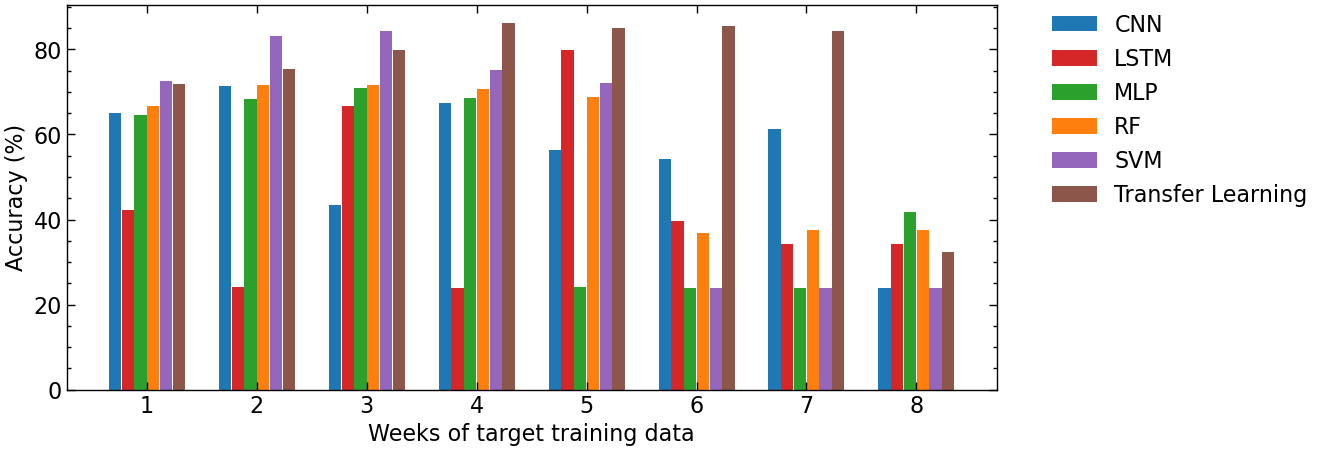

C:\Users\Vincent\AppData\Local\Temp\ipykernel_18620\221785584.py:135: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combination_df_tl = df_filtered[(df_filtered['learning_rate'] == best_tl[0]) & (df_filtered['extra layer'] == best_tl[1]) & (df_filtered['freeze first'] == best_tl[2]) & (df['freeze second'] == best_tl[3]) & (df_filtered['Source'] == best_tl[4]) & (df_filtered['Transfer learning'] == True)].sort_values('split_size')


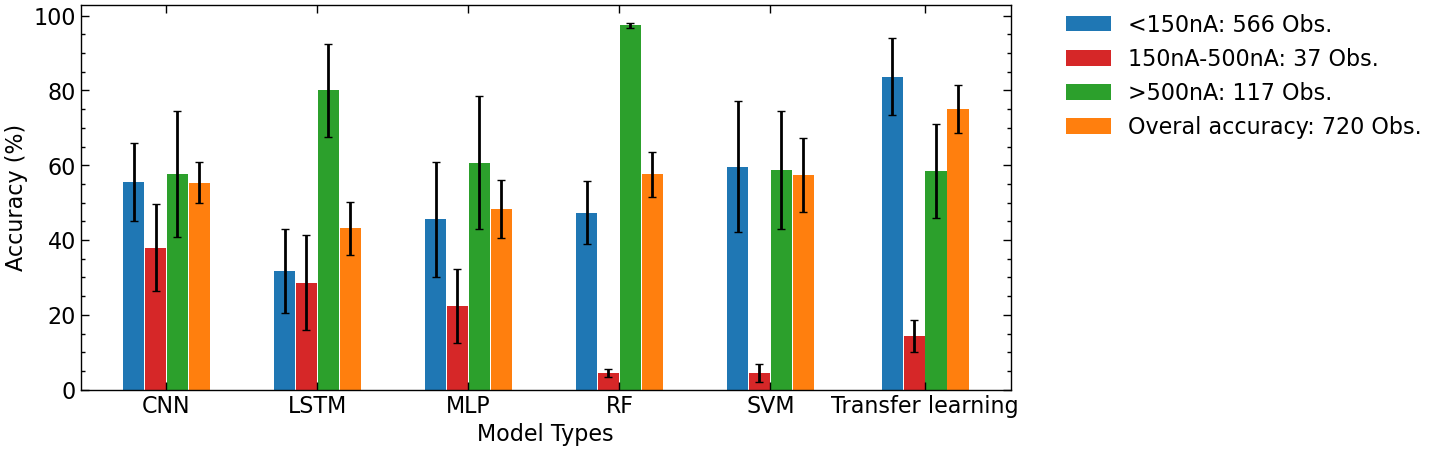

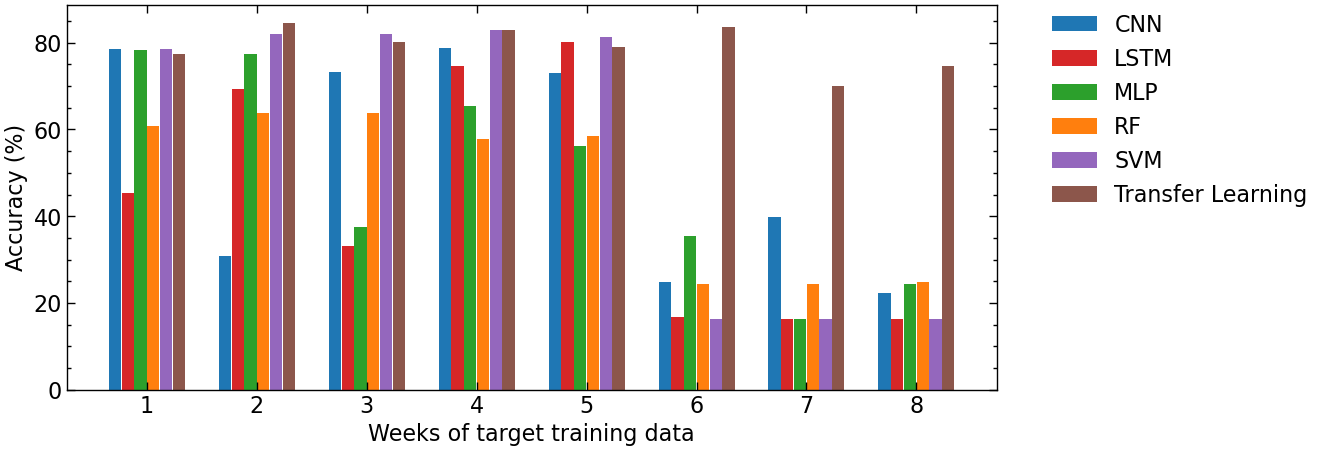

C:\Users\Vincent\AppData\Local\Temp\ipykernel_18620\221785584.py:135: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combination_df_tl = df_filtered[(df_filtered['learning_rate'] == best_tl[0]) & (df_filtered['extra layer'] == best_tl[1]) & (df_filtered['freeze first'] == best_tl[2]) & (df['freeze second'] == best_tl[3]) & (df_filtered['Source'] == best_tl[4]) & (df_filtered['Transfer learning'] == True)].sort_values('split_size')


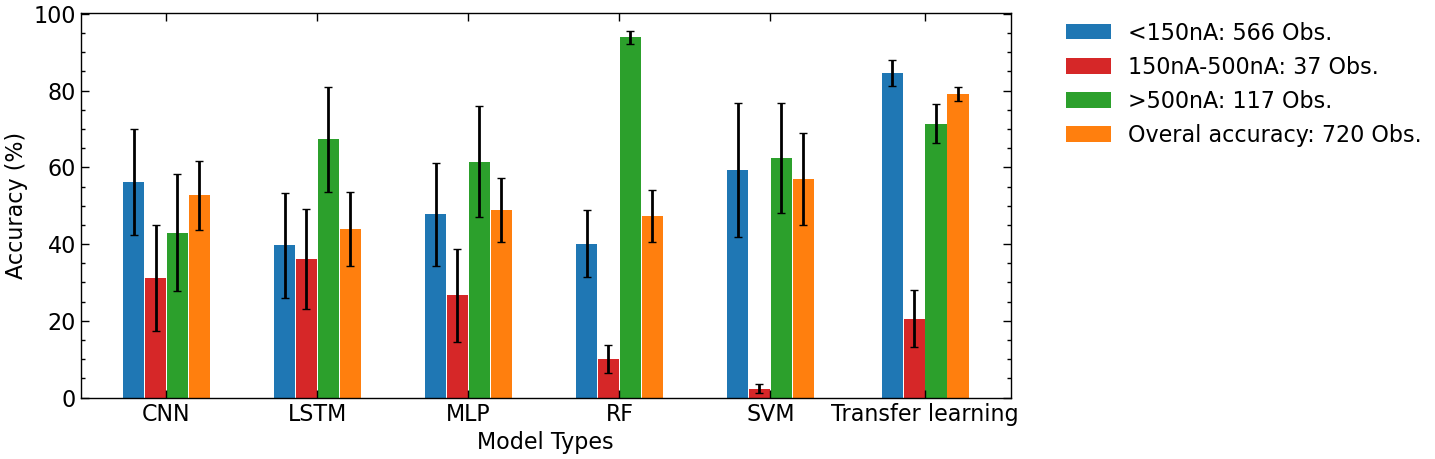

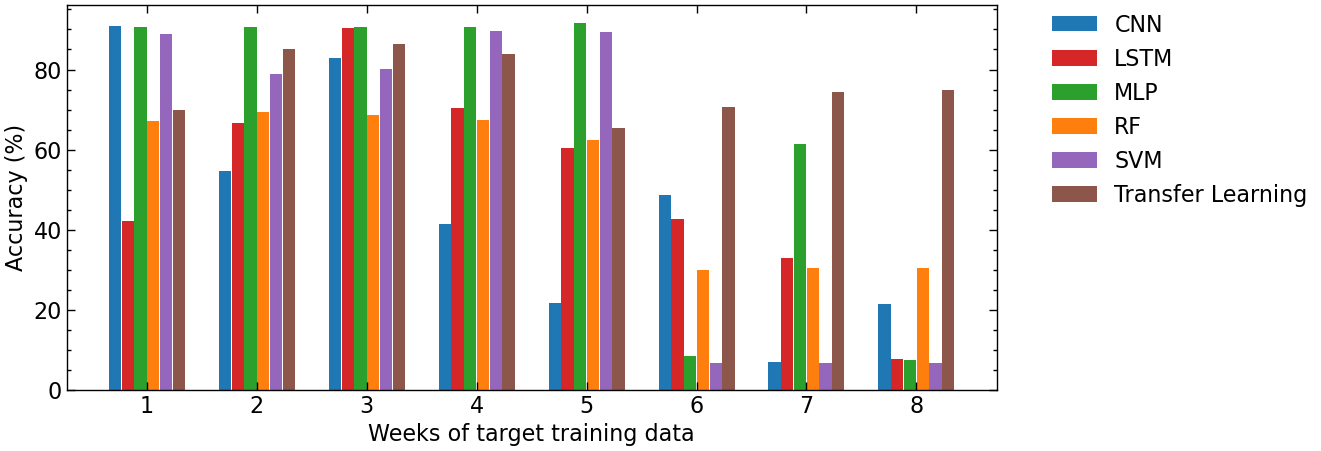

C:\Users\Vincent\AppData\Local\Temp\ipykernel_18620\221785584.py:135: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combination_df_tl = df_filtered[(df_filtered['learning_rate'] == best_tl[0]) & (df_filtered['extra layer'] == best_tl[1]) & (df_filtered['freeze first'] == best_tl[2]) & (df['freeze second'] == best_tl[3]) & (df_filtered['Source'] == best_tl[4]) & (df_filtered['Transfer learning'] == True)].sort_values('split_size')


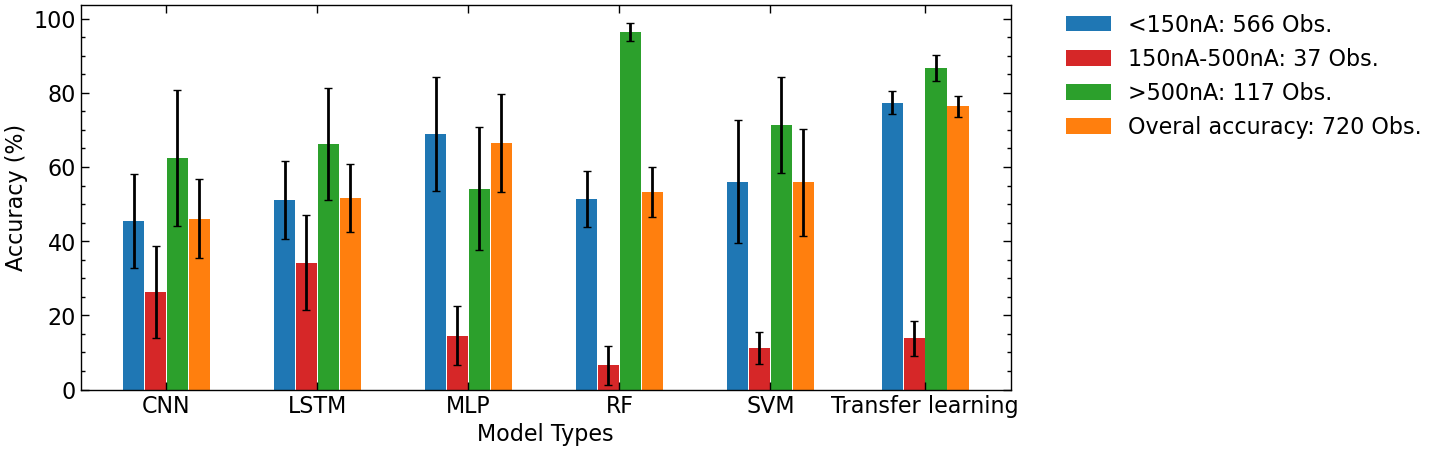

In [7]:
# Define a function to compute the mean and standard error of the mean (SEM) for each accuracy category
def get_mean_and_sem(df, model_type, category, num_weeks=None):
    data = df[df['model_type'] == model_type][category]
    mean = data[:num_weeks].mean()
    sem = data.sem()
    return mean, sem

plt.style.use('default')
plt.style.use(['science', 'notebook'])

colors = mcolors.TABLEAU_COLORS
colors = [colors['tab:blue'], colors['tab:red'], colors['tab:green'], colors['tab:orange'], colors['tab:purple'], colors['tab:brown']]

weeks = 8

df = pd.read_excel("Modelling_results_TL_benchmark_july_august_september_best_TL.xlsx")

df[['Below 150 nA', '150-500', 'greater 500 nA', 'overal_accuracy']] *= 100
# Calculate top 5 combinations for transfer learning
# Filter the main DataFrame 'df' based on the first 'weeks' unique values of split_sizes
unique_split_sizes = sorted(df['split_size'].unique())
split_sizes_first_weeks = unique_split_sizes[:weeks]
df = df[df['split_size'].isin(split_sizes_first_weeks)]

unique_combinations_df = df[['begin_testsplit', 'end_testsplit']].drop_duplicates()
testsplit_combinations = [tuple(x) for x in unique_combinations_df.to_numpy()]

results_dict = {}

for testsplit_range in testsplit_combinations:
    begin_testsplit, end_testsplit = testsplit_range

    # Filter the data based on the begin_testsplit and end_testsplit values
    df_filtered = df[(df['begin_testsplit'] == begin_testsplit) & (df['end_testsplit'] == end_testsplit)]

    # Now replace all occurrences of df in the existing code with df_filtered, without overwriting the original DataFrame
    grouped_tl = df_filtered.groupby(['learning_rate', 'extra layer', 'freeze first', 'freeze second', 'Source', 'Transfer learning'])
    mean_overall_accuracy_tl = grouped_tl['overal_accuracy'].mean()
    top_5_combinations_tl = mean_overall_accuracy_tl.xs(True, level='Transfer learning').nlargest(1)

    # Filter out rows where Transfer learning is set to False
    df_no_tl = df_filtered[df_filtered['Transfer learning'] == False]

    # Group by split_size and model_type, and then aggregate by taking the mean of overal_accuracy
    grouped = df_no_tl.groupby(['split_size', 'model_type'])['overal_accuracy'].mean().reset_index()

    # Sort the grouped data by split_size
    grouped = grouped.sort_values('split_size')

    # Get the unique model_types and split_sizes
    model_types = grouped['model_type'].unique()
    split_sizes = grouped['split_size'].unique()

    # Define the width of the bars and the number of bars per group
    bar_width = 0.2
    num_bars_per_group = len(model_types) + 1  # Adding one more bar for transfer learning

    # Set up the x-axis values for the bars
    x_splits = np.arange(len(split_sizes))

    # Define the width of the bars, a small spacing between each column of every clustered column, and the spacing between clusters
    bar_width = 0.14
    column_spacing = 0.005
    cluster_spacing = 0.25

    # Set up the x-axis values for the bars
    x_models = np.arange(len(model_types))
    accuracy_categories = ['<150nA', '150nA-500nA', '>500nA', 'Overal accuracy']
    for idx, combination in enumerate(top_5_combinations_tl.index):
        fig, ax = plt.subplots(figsize=(12, 5))

        for i, model_type in enumerate(model_types):
            ax.bar(x_splits + i * (bar_width + column_spacing) + cluster_spacing * x_splits,
                   grouped[grouped['model_type'] == model_type]['overal_accuracy'],
                   width=bar_width,
                   color=colors[i],
                   linewidth=1,
                   label=model_type)

        combination_df_tl = grouped_tl.get_group((*combination, True))
        combination_df_tl = combination_df_tl.sort_values('split_size')

        ax.bar(x_splits + len(model_types) * (bar_width + column_spacing) + cluster_spacing * x_splits,
               combination_df_tl['overal_accuracy'],
               width=bar_width,
               color=colors[len(model_types)],
               linewidth=1,
               label='Transfer Learning')

        ax.set_xticks(x_splits + (num_bars_per_group - 1) * (bar_width + column_spacing) / 2 + cluster_spacing * x_splits)
        ax.set_xticklabels(range(1, len(split_sizes) + 1))  # Replace the x-axis tick labels with 1, 2, 3, etc.

        # Remove minor ticks on the x-axis
        ax.set_xticks([], minor=True)

        ax.set_ylabel('Accuracy (%)', fontsize = 16)

        # Add an overarching x-axis label "Weeks of target training/fine-tuning data"
        ax.set_xlabel('Weeks of target training data', fontsize = 16)

#         ax.set_title(f'Clustered Column Graph of Overal Accuracy by Model Type and Split Size with Transfer Learning\n(Learning rate = {combination[0]}, Extra layer = {combination[1]}, Freeze first = {combination[2]}, Freeze second = {combination[3]}, Source = {combination[4]})')
    #     handles, labels = ax.get_legend_handles_labels()
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        plt.show()

        # Now the bar plots for the split_size average accuracy values

        fig, ax = plt.subplots(figsize=(12, 5))

        # Iterate over the accuracy categories
        accuracy_categories = ['Below 150 nA', '150-500', 'greater 500 nA', 'overal_accuracy']
        for i, category in enumerate(accuracy_categories):
            means = []
            sems = []
            for model_type in model_types:
                mean, sem = get_mean_and_sem(df_no_tl, model_type, category, num_weeks=weeks)  # Use df_no_tl here
                means.append(mean)
                sems.append(sem)

            # Plot the bars with error bars
            x_vals = x_models + i * (bar_width + column_spacing)
            ax.bar(x_vals, means, yerr=sems, width=bar_width, color=colors[i], linewidth=1, label=category, capsize=3)

        # Plot the bars for the top 5 transfer learning approaches
        # Add transfer learning columns
        # Add the best transfer learning approach
        
        best_tl = top_5_combinations_tl.index[idx]
        combination_df_tl = df_filtered[(df_filtered['learning_rate'] == best_tl[0]) & (df_filtered['extra layer'] == best_tl[1]) & (df_filtered['freeze first'] == best_tl[2]) & (df['freeze second'] == best_tl[3]) & (df_filtered['Source'] == best_tl[4]) & (df_filtered['Transfer learning'] == True)].sort_values('split_size')
        x_tl = x_models[-1] + 1 * (bar_width + column_spacing)

        # Calculate the mean and SEM for each accuracy category
        below_150_mean, below_150_sem = combination_df_tl['Below 150 nA'].mean(), combination_df_tl['Below 150 nA'].sem()
        between_150_500_mean, between_150_500_sem = combination_df_tl['150-500'].mean(), combination_df_tl['150-500'].sem()
        greater_500_mean, greater_500_sem = combination_df_tl['greater 500 nA'].mean(), combination_df_tl['greater 500 nA'].sem()
        overall_accuracy_mean, overall_accuracy_sem = combination_df_tl['overal_accuracy'].mean(), combination_df_tl['overal_accuracy'].sem()

        # Compute the total width of a cluster of columns
        total_cluster_width = (bar_width + column_spacing) * len(accuracy_categories) - column_spacing

        # Adjust the x-axis values for the transfer learning cluster
        x_tl = x_models[-1] + total_cluster_width + cluster_spacing * 1.8

        # Plot the bars with error bars for transfer learning
        x_vals = [x_tl + j * (bar_width + column_spacing) for j in range(4)]
        means = [below_150_mean, between_150_500_mean, greater_500_mean, overall_accuracy_mean]
        sems = [below_150_sem, between_150_500_sem, greater_500_sem, overall_accuracy_sem]

        for i in range(4):
            bar = ax.bar(x_vals[i], means[i], yerr=sems[i], width=bar_width, color=colors[i], linewidth=1, capsize=3)

        ax.set_xticks(np.append(x_models, x_tl) + (len(accuracy_categories) - 1) * (bar_width + column_spacing) / 2)
        ax.set_xticklabels(model_types.tolist() + ['Transfer learning'])

        # Remove minor ticks on the x-axis
        ax.set_xticks([], minor=True)

        ax.set_ylabel('Accuracy (%)', fontsize = 16)

        # Add an overarching x-axis label "Model Types"
        ax.set_xlabel('Model Types', fontsize = 16)

#         ax.set_title(f'Clustered Column Graph of different models and TL of the mean accuracy values of the different split sizes\n(Learning rate = {best_tl[0]}, Extra layer = {best_tl[1]}, Freeze first = {best_tl[2]}, Freeze second = {best_tl[3]}, Source = {best_tl[4]})')
        # Remove 'Best TL' from the legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:4], ['<150nA: 566 Obs.', '150nA-500nA: 37 Obs.', '>500nA: 117 Obs.', 'Overal accuracy: 720 Obs.'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        plt.show()
    

### Results of last 4 weeks TL vs benchmark models

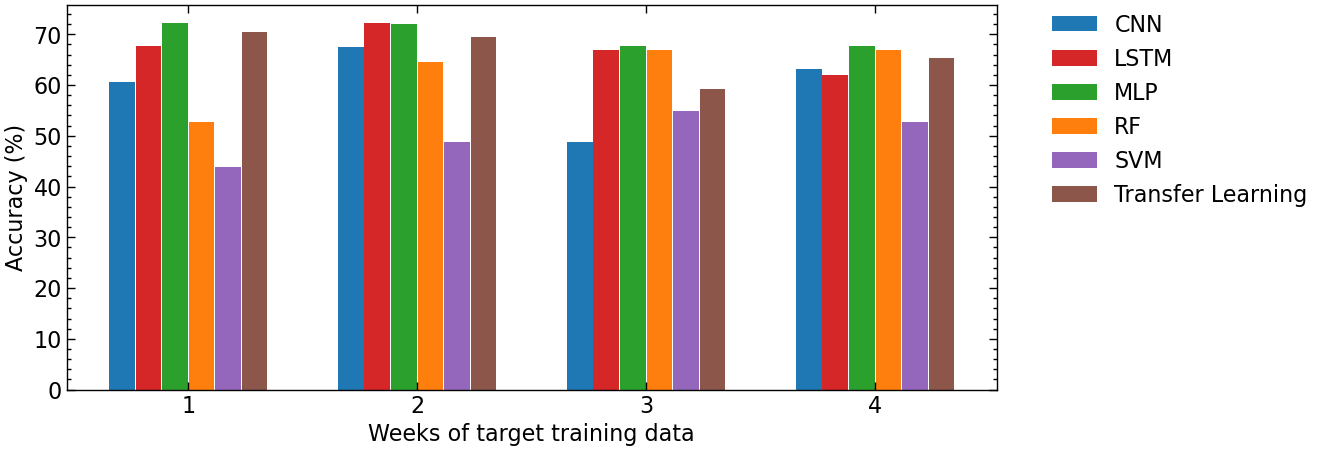

C:\Users\Vincent\AppData\Local\Temp\ipykernel_18620\635150197.py:136: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combination_df_tl = df_filtered[(df_filtered['learning_rate'] == best_tl[0]) & (df_filtered['extra layer'] == best_tl[1]) & (df_filtered['freeze first'] == best_tl[2]) & (df['freeze second'] == best_tl[3]) & (df_filtered['Source'] == best_tl[4]) & (df_filtered['Transfer learning'] == True)].sort_values('split_size')


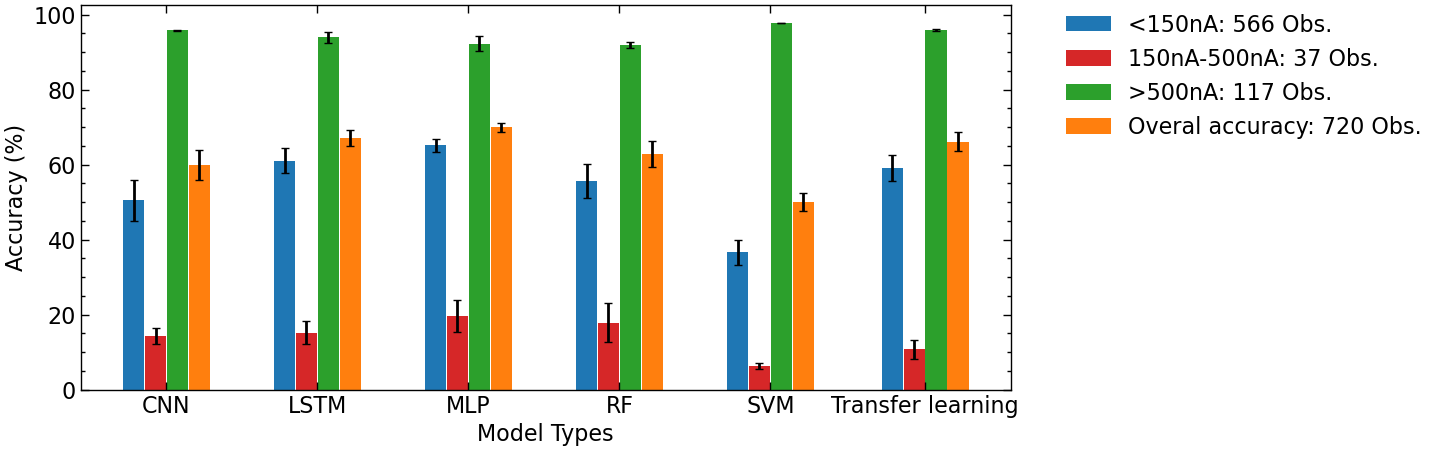

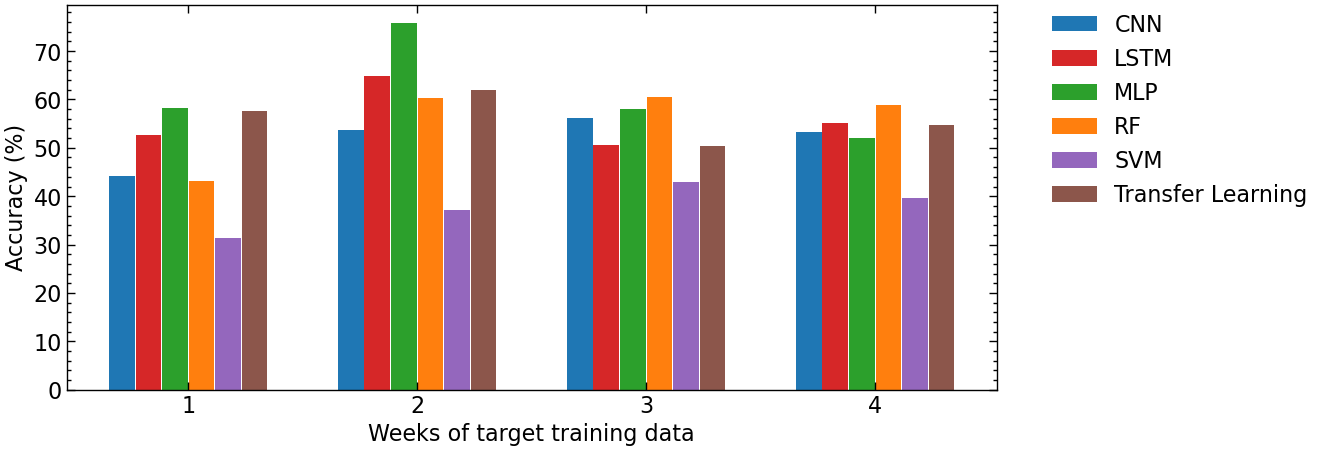

C:\Users\Vincent\AppData\Local\Temp\ipykernel_18620\635150197.py:136: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combination_df_tl = df_filtered[(df_filtered['learning_rate'] == best_tl[0]) & (df_filtered['extra layer'] == best_tl[1]) & (df_filtered['freeze first'] == best_tl[2]) & (df['freeze second'] == best_tl[3]) & (df_filtered['Source'] == best_tl[4]) & (df_filtered['Transfer learning'] == True)].sort_values('split_size')


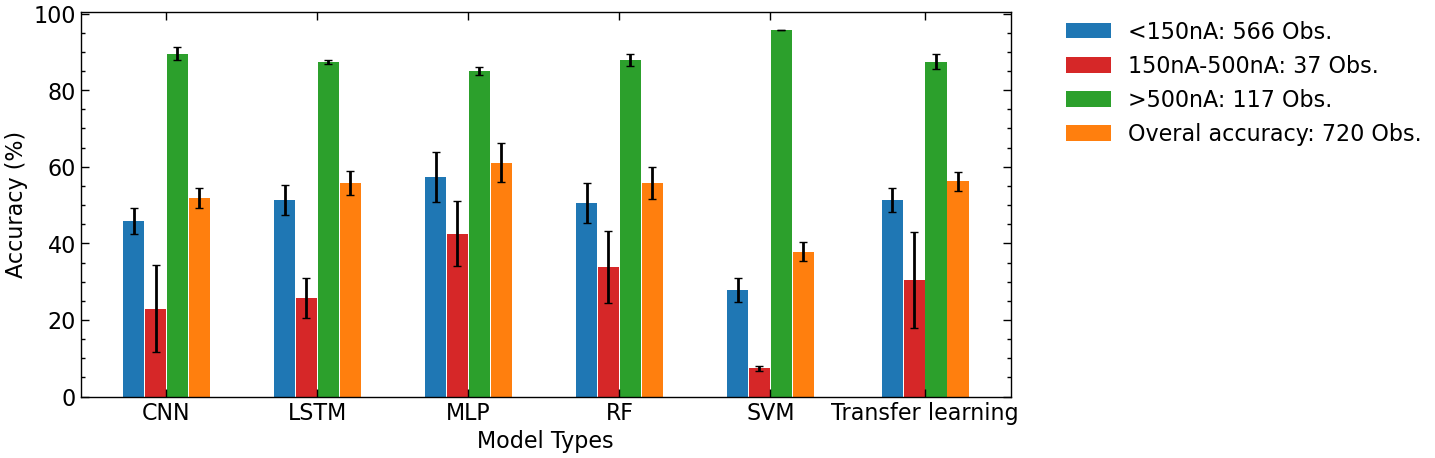

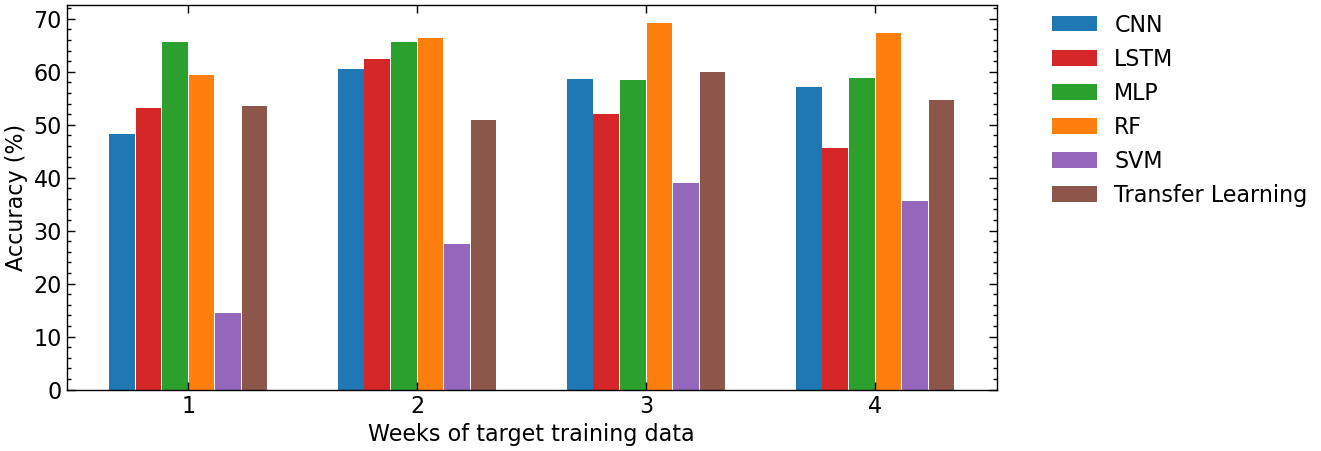

C:\Users\Vincent\AppData\Local\Temp\ipykernel_18620\635150197.py:136: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combination_df_tl = df_filtered[(df_filtered['learning_rate'] == best_tl[0]) & (df_filtered['extra layer'] == best_tl[1]) & (df_filtered['freeze first'] == best_tl[2]) & (df['freeze second'] == best_tl[3]) & (df_filtered['Source'] == best_tl[4]) & (df_filtered['Transfer learning'] == True)].sort_values('split_size')


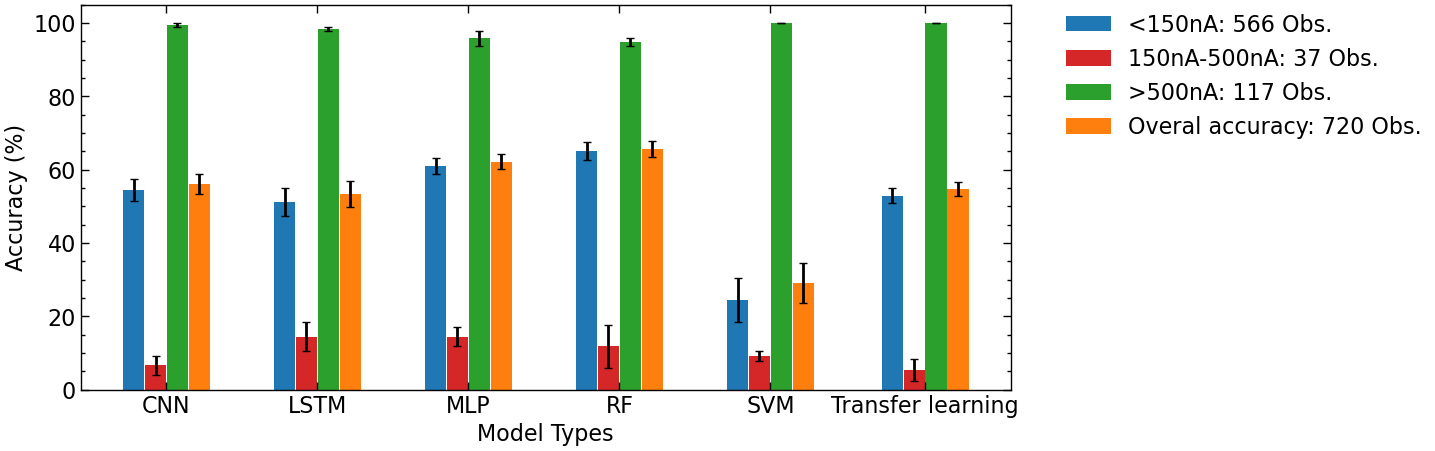

In [6]:
# Define a function to compute the mean and standard error of the mean (SEM) for each accuracy category
def get_mean_and_sem(df, model_type, category, num_weeks=None):
    data = df[df['model_type'] == model_type][category]
    mean = data[:num_weeks].mean()
    sem = data.sem()
    return mean, sem

plt.style.use('default')
plt.style.use(['science', 'notebook'])

colors = mcolors.TABLEAU_COLORS
colors = [colors['tab:blue'], colors['tab:red'], colors['tab:green'], colors['tab:orange'], colors['tab:purple'], colors['tab:brown']]

weeks = 4

# Assuming your data is in a pandas DataFrame called df
df = pd.read_excel("Modelling_results_TL_benchmark_july_august_september_best_TL.xlsx") # correct one

df[['Below 150 nA', '150-500', 'greater 500 nA', 'overal_accuracy']] *= 100
# Calculate top 5 combinations for transfer learning
# Filter the main DataFrame 'df' based on the first 'weeks' unique values of split_sizes
unique_split_sizes = sorted(df['split_size'].unique())
split_sizes_last_weeks = unique_split_sizes[-weeks:]  # Select the last 'weeks' unique values
df = df[df['split_size'].isin(split_sizes_last_weeks)]
unique_combinations_df = df[['begin_testsplit', 'end_testsplit']].drop_duplicates()
testsplit_combinations = [tuple(x) for x in unique_combinations_df.to_numpy()]

results_dict = {}

for testsplit_range in testsplit_combinations:
    begin_testsplit, end_testsplit = testsplit_range

    # Filter the data based on the begin_testsplit and end_testsplit values
    df_filtered = df[(df['begin_testsplit'] == begin_testsplit) & (df['end_testsplit'] == end_testsplit)]

    # Now replace all occurrences of df in the existing code with df_filtered, without overwriting the original DataFrame

    grouped_tl = df_filtered.groupby(['learning_rate', 'extra layer', 'freeze first', 'freeze second', 'Source', 'Transfer learning'])
    mean_overall_accuracy_tl = grouped_tl['overal_accuracy'].mean()
    top_5_combinations_tl = mean_overall_accuracy_tl.xs(True, level='Transfer learning').nlargest(1)

    # Filter out rows where Transfer learning is set to False
    df_no_tl = df_filtered[df_filtered['Transfer learning'] == False]

    # Group by split_size and model_type, and then aggregate by taking the mean of overal_accuracy
    grouped = df_no_tl.groupby(['split_size', 'model_type'])['overal_accuracy'].mean().reset_index()

    # Sort the grouped data by split_size
    grouped = grouped.sort_values('split_size')

    # Get the unique model_types and split_sizes
    model_types = grouped['model_type'].unique()
    split_sizes = grouped['split_size'].unique()

    # Define the width of the bars and the number of bars per group
    bar_width = 0.2
    num_bars_per_group = len(model_types) + 1  # Adding one more bar for transfer learning

    # Set up the x-axis values for the bars
    x_splits = np.arange(len(split_sizes))

    # Define the width of the bars, a small spacing between each column of every clustered column, and the spacing between clusters
    bar_width = 0.14
    column_spacing = 0.005
    cluster_spacing = 0.25

    # Set up the x-axis values for the bars
    x_models = np.arange(len(model_types))
    accuracy_categories = ['<150nA', '150nA-500nA', '>500nA', 'Overal accuracy']
    for idx, combination in enumerate(top_5_combinations_tl.index):
        fig, ax = plt.subplots(figsize=(12, 5))

        for i, model_type in enumerate(model_types):
            ax.bar(x_splits + i * (bar_width + column_spacing) + cluster_spacing * x_splits,
                   grouped[grouped['model_type'] == model_type]['overal_accuracy'],
                   width=bar_width,
                   color=colors[i],
                   linewidth=1,
                   label=model_type)

        combination_df_tl = grouped_tl.get_group((*combination, True))
        combination_df_tl = combination_df_tl.sort_values('split_size')

        ax.bar(x_splits + len(model_types) * (bar_width + column_spacing) + cluster_spacing * x_splits,
               combination_df_tl['overal_accuracy'],
               width=bar_width,
               color=colors[len(model_types)],
               linewidth=1,
               label='Transfer Learning')

        ax.set_xticks(x_splits + (num_bars_per_group - 1) * (bar_width + column_spacing) / 2 + cluster_spacing * x_splits)
        ax.set_xticklabels(range(1, len(split_sizes) + 1))  # Replace the x-axis tick labels with 1, 2, 3, etc.

        # Remove minor ticks on the x-axis
        ax.set_xticks([], minor=True)

        ax.set_ylabel('Accuracy (%)', fontsize = 16)

        # Add an overarching x-axis label "Weeks of target training/fine-tuning data"
        ax.set_xlabel('Weeks of target training data', fontsize = 16)

#         ax.set_title(f'Clustered Column Graph of Overal Accuracy by Model Type and Split Size with Transfer Learning\n(Learning rate = {combination[0]}, Extra layer = {combination[1]}, Freeze first = {combination[2]}, Freeze second = {combination[3]}, Source = {combination[4]})')
    #     handles, labels = ax.get_legend_handles_labels()
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        plt.show()

        # Now the bar plots for the split_size average accuracy values

        fig, ax = plt.subplots(figsize=(12, 5))

        # Iterate over the accuracy categories
        accuracy_categories = ['Below 150 nA', '150-500', 'greater 500 nA', 'overal_accuracy']
        for i, category in enumerate(accuracy_categories):
            means = []
            sems = []
            for model_type in model_types:
                mean, sem = get_mean_and_sem(df_no_tl, model_type, category, num_weeks=weeks)  # Use df_no_tl here
                means.append(mean)
                sems.append(sem)

            # Plot the bars with error bars
            x_vals = x_models + i * (bar_width + column_spacing)
            ax.bar(x_vals, means, yerr=sems, width=bar_width, color=colors[i], linewidth=1, label=category, capsize=3)

        # Plot the bars for the top 5 transfer learning approaches
        # Add transfer learning columns
        # Add the best transfer learning approach
        
        best_tl = top_5_combinations_tl.index[idx]
        combination_df_tl = df_filtered[(df_filtered['learning_rate'] == best_tl[0]) & (df_filtered['extra layer'] == best_tl[1]) & (df_filtered['freeze first'] == best_tl[2]) & (df['freeze second'] == best_tl[3]) & (df_filtered['Source'] == best_tl[4]) & (df_filtered['Transfer learning'] == True)].sort_values('split_size')
        x_tl = x_models[-1] + 1 * (bar_width + column_spacing)

        # Calculate the mean and SEM for each accuracy category
        below_150_mean, below_150_sem = combination_df_tl['Below 150 nA'].mean(), combination_df_tl['Below 150 nA'].sem()
        between_150_500_mean, between_150_500_sem = combination_df_tl['150-500'].mean(), combination_df_tl['150-500'].sem()
        greater_500_mean, greater_500_sem = combination_df_tl['greater 500 nA'].mean(), combination_df_tl['greater 500 nA'].sem()
        overall_accuracy_mean, overall_accuracy_sem = combination_df_tl['overal_accuracy'].mean(), combination_df_tl['overal_accuracy'].sem()

        # Compute the total width of a cluster of columns
        total_cluster_width = (bar_width + column_spacing) * len(accuracy_categories) - column_spacing

        # Adjust the x-axis values for the transfer learning cluster
        x_tl = x_models[-1] + total_cluster_width + cluster_spacing * 1.8

        # Plot the bars with error bars for transfer learning
        x_vals = [x_tl + j * (bar_width + column_spacing) for j in range(4)]
        means = [below_150_mean, between_150_500_mean, greater_500_mean, overall_accuracy_mean]
        sems = [below_150_sem, between_150_500_sem, greater_500_sem, overall_accuracy_sem]

        for i in range(4):
            bar = ax.bar(x_vals[i], means[i], yerr=sems[i], width=bar_width, color=colors[i], linewidth=1, capsize=3)

        ax.set_xticks(np.append(x_models, x_tl) + (len(accuracy_categories) - 1) * (bar_width + column_spacing) / 2)
        ax.set_xticklabels(model_types.tolist() + ['Transfer learning'])

        # Remove minor ticks on the x-axis
        ax.set_xticks([], minor=True)

        ax.set_ylabel('Accuracy (%)', fontsize = 16)

        # Add an overarching x-axis label "Model Types"
        ax.set_xlabel('Model Types', fontsize = 16)

#         ax.set_title(f'Clustered Column Graph of different models and TL of the mean accuracy values of the different split sizes\n(Learning rate = {best_tl[0]}, Extra layer = {best_tl[1]}, Freeze first = {best_tl[2]}, Freeze second = {best_tl[3]}, Source = {best_tl[4]})')
        # Remove 'Best TL' from the legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:4], ['<150nA: 566 Obs.', '150nA-500nA: 37 Obs.', '>500nA: 117 Obs.', 'Overal accuracy: 720 Obs.'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        plt.show()
    

### Generate table values that checks what approach works best for what learning rate

In [ ]:
# Load the data
df = pd.read_excel("Modelling_results_TL_benchmark_july_august_september_all_data.xlsx")

# Filter data for the first 8 weeks and transfer learning
unique_split_sizes = sorted(df['split_size'].unique())
split_sizes_first_weeks = unique_split_sizes[:8]
df = df[(df['split_size'].isin(split_sizes_first_weeks)) & (df['Transfer learning'] == True)]

unique_combinations_df = df[['begin_testsplit', 'end_testsplit']].drop_duplicates()
testsplit_combinations = [tuple(x) for x in unique_combinations_df.to_numpy()]

# Define a function to categorize the approach
def categorize_approach(row):
    if row['extra layer'] == True and row['freeze first'] == False and row['freeze second'] == False:
        return 'extra layer'
    elif row['extra layer'] == False and row['freeze first'] == True and row['freeze second'] == False:
        return 'freeze first'
    elif row['extra layer'] == False and row['freeze first'] == False and row['freeze second'] == True:
        return 'freeze second'
    elif row['extra layer'] == False and row['freeze first'] == False and row['freeze second'] == False:
        return 'freeze none'
    else:
        return 'unknown'  # just in case there are rows that don't fit any category

pivot_tables = []
for testsplit_range in testsplit_combinations:
    begin_testsplit, end_testsplit = testsplit_range

    # Filter the data based on the begin_testsplit and end_testsplit values
    df_filtered = df[(df['begin_testsplit'] == begin_testsplit) & (df['end_testsplit'] == end_testsplit)]
    # Add the approach column
    df_filtered['approach'] = df_filtered.apply(categorize_approach, axis=1)

    # Aggregate the data and create a pivot table
    pivot_table = pd.pivot_table(df_filtered, values='overal_accuracy', index='learning_rate',
                                 columns='approach', aggfunc=np.mean)

    # Display the pivot table
    print(pivot_table)
    pivot_tables.append(pivot_table)

# Now outside the loop, you can combine the pivot tables
combined_table = pd.concat(pivot_tables)

# Calculate the mean of the combined table
averaged_table = combined_table.groupby(level=combined_table.index.names).mean()

# Display the averaged table
print(averaged_table)

### check how many samples there are in the dataset for the different intervals

In [39]:
begin_testsplit = [0.4198, 0.51, 0.595] # three months
end_testsplit = [0.509, 0.595, 0.6797]
for idx, (begin_split, end_split) in enumerate(zip(begin_testsplit, end_testsplit)):
    # Assuming df1 is already defined with 'Galvanic current (nA)' column
    df_august = df1['Galvanic current (nA)'].iloc[int(len(df1)*begin_split):int(len(df1)*end_split)]
    print(df_august.head())
    print(df_august.tail())
    # Count samples in each category
    below_150 = (df_august < 150).sum()
    between_150_500 = ((df_august >= 150) & (df_august <= 500)).sum()
    greater_than_500 = (df_august > 500).sum()

    print(f"Number of samples below 150 nA: {below_150}")
    print(f"Number of samples between 150-500 nA: {between_150_500}")
    print(f"Number of samples greater than 500 nA: {greater_than_500}")

date
2021-06-30 23:00:00    34.886613
2021-07-01 00:00:00    35.232623
2021-07-01 01:00:00    38.694918
2021-07-01 02:00:00    40.799000
2021-07-01 03:00:00    47.427167
Name: Galvanic current (nA), dtype: float64
date
2021-08-01 16:00:00    25.835738
2021-08-01 17:00:00    31.287097
2021-08-01 18:00:00    33.983167
2021-08-01 19:00:00    39.803667
2021-08-01 20:00:00    60.684333
Name: Galvanic current (nA), dtype: float64
Number of samples below 150 nA: 548
Number of samples between 150-500 nA: 28
Number of samples greater than 500 nA: 180
date
2021-08-02 05:00:00    224.966333
2021-08-02 06:00:00    155.297500
2021-08-02 07:00:00    106.566230
2021-08-02 08:00:00     61.383667
2021-08-02 09:00:00     33.290500
Name: Galvanic current (nA), dtype: float64
date
2021-09-01 00:00:00    34.407000
2021-09-01 01:00:00    38.234833
2021-09-01 02:00:00    45.164833
2021-09-01 03:00:00    90.185333
2021-09-01 04:00:00    69.266984
Name: Galvanic current (nA), dtype: float64
Number of samples b

### Augmented Dickey-fuller test as part of the EDA

In [19]:
df_outdoor = df1.iloc[:int(len(df1)*0.68)]
df_acc_sae_stable = df_acc_sae.iloc[int(len(df_acc_sae)*0.62):]

def clean_column(df, column_name):
    df[column_name] = df[column_name].replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=[column_name])
    return df

def log_transform_column(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: np.log(x) if x > 0 else np.nan)
    return df

def check_stationarity(df, column_name):
    result = adfuller(df[column_name].dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical values:")
    for key, value in result[4].items():
        print(f"{key}: {value}")

    if result[1] <= 0.05:
        print(f"Data in column '{column_name}' is stationary")
    else:
        print(f"Data in column '{column_name}' is not stationary")

# Clean the 'Galvanic current (nA)' column in all dataframes
df_outdoor = clean_column(df_outdoor, 'Galvanic current (nA)')
df_acc_sae_stable = clean_column(df_acc_sae_stable, 'Galvanic current (nA)')
df_acc_sae = clean_column(df_acc_sae, 'Galvanic current (nA)')

# Apply log transformation to the 'Galvanic current (nA)' column in all dataframes
df_outdoor = log_transform_column(df_outdoor, 'Galvanic current (nA)')
df_acc_sae_stable = log_transform_column(df_acc_sae_stable, 'Galvanic current (nA)')
df_acc_sae = log_transform_column(df_acc_sae, 'Galvanic current (nA)')

# Check stationarity for all dataframes
print("Stationarity test for 'Galvanic current (nA)' in df_outdoor:")
check_stationarity(df_outdoor, 'Galvanic current (nA)')
print("\nStationarity test for 'Galvanic current (nA)' in df_acc_sae_stable:")
check_stationarity(df_acc_sae_stable, 'Galvanic current (nA)')
print("\nStationarity test for 'Galvanic current (nA)' in df_acc_sae:")
check_stationarity(df_acc_sae, 'Galvanic current (nA)')


C:\Users\Vincent\AppData\Local\Temp\ipykernel_23132\1555699741.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].replace([np.inf, -np.inf], np.nan)
C:\Users\Vincent\AppData\Local\Temp\ipykernel_23132\1555699741.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].replace([np.inf, -np.inf], np.nan)
C:\Users\Vincent\AppData\Local\Temp\ipykernel_23132\1555699741.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Stationarity test for 'Galvanic current (nA)' in df_outdoor:
ADF Statistic: -9.464585987229064
p-value: 4.263737359711696e-16
Critical values:
1%: -3.4314927483800766
5%: -2.862044985289949
10%: -2.567038801861139
Data in column 'Galvanic current (nA)' is stationary

Stationarity test for 'Galvanic current (nA)' in df_acc_sae_stable:
ADF Statistic: -8.657615352503825
p-value: 4.920123652028847e-14
Critical values:
1%: -3.4474946672686824
5%: -2.8690962436986855
10%: -2.570795299750434
Data in column 'Galvanic current (nA)' is stationary

Stationarity test for 'Galvanic current (nA)' in df_acc_sae:
ADF Statistic: -1.876474762347106
p-value: 0.3432077526238313
Critical values:
1%: -3.4374162506455126
5%: -2.8646595140022946
10%: -2.568431020409111
Data in column 'Galvanic current (nA)' is not stationary
